# HW Review

In [115]:
import pandas as pd
import numpy as np
import datetime
import holidays

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression
import warnings
from scipy.optimize import minimize
from scipy import interpolate
from scipy.optimize import fsolve
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

def semi_bootstrap(params,maturity, n_compound):
    estimated_maturities = params[0]
    betas = params[1]
    estimated_rates = discount_to_intrate(betas,estimated_maturities, n_compound=n_compound)
    
    f = interpolate.interp1d(estimated_maturities, estimated_rates, bounds_error=False, fill_value='extrapolate')
    
    rate = f(maturity)

    return rate


def bday(date):
    """
    Check if a given date is a business day in the US.

    Parameters:
    date (datetime.date): The date to check.

    Returns:
    bool: True if the date is a business day, False otherwise.
    """
    us_bus = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    return bool(len(pd.bdate_range(date, date, freq=us_bus)))

def prev_bday(date, force_prev=False):
    """
    Returns the previous business day given a date.

    Parameters:
    date (str or datetime.datetime): The input date in the format 'YYYY-MM-DD' or as a datetime object.
    force_prev (bool, optional): If True, forces the function to return the previous business day even if the input date is already a business day. Defaults to False.

    Returns:
    str or datetime.datetime: The previous business day as a string in the format 'YYYY-MM-DD' if the input date is a string, or as a datetime object if the input date is a datetime object.
    """
    if isinstance(date, str):
        date = datetime.datetime.strptime(date, '%Y-%m-%d')
        date2str = True
    else:
        date2str = False
        
    if force_prev:
        date += -datetime.timedelta(days=1)
    while not bday(date):
        date += -datetime.timedelta(days=1)
    
    if date2str:
        date = date.strftime('%Y-%m-%d')
        
    return date

def get_coupon_dates(quote_date, maturity_date):
    """
    Returns a list of coupon dates between the quote date and maturity date.

    Parameters:
    quote_date (str or datetime.datetime): The quote date in the format 'YYYY-MM-DD' or as a datetime object.
    maturity_date (str or datetime.datetime): The maturity date in the format 'YYYY-MM-DD' or as a datetime object.

    Returns:
    list: A list of coupon dates between the quote date and maturity date.
    """
    if isinstance(quote_date, str):
        quote_date = datetime.datetime.strptime(quote_date, '%Y-%m-%d')
        
    if isinstance(maturity_date, str):
        maturity_date = datetime.datetime.strptime(maturity_date, '%Y-%m-%d')
    
    # divide by 180 just to be safe
    temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date - quote_date).days / 180), freq=pd.DateOffset(months=6))
    # filter out if one date too many
    temp = pd.DataFrame(data=temp[temp > quote_date])

    out = temp[0]
    return out



def make_figure_number_issues_paying(CFmatrix):
    """
    Creates a figure showing the number of treasury issues with coupon or principal payment over time.

    Parameters:
    CFmatrix (numpy.ndarray): The cash flow matrix representing the treasury issues.

    Returns:
    None
    """
    mask_issues_paying = (CFmatrix!=0).sum()

    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(mask_issues_paying,marker='*',linestyle='None')

    #set ticks every quarter
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(2,5,8,11)))
    ax.xaxis.set_major_locator(mdates.YearLocator(month=2))

    #format ticks
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=60, horizontalalignment='right')

    ax.margins(x=0)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

    plt.ylabel('number of treasury issues with coupon or principal payment')
    plt.title('Number of Treasuries Paying')

    plt.show()



def filter_treasuries(data, t_date=None, filter_maturity=None, filter_maturity_min=None, drop_duplicate_maturities=False, filter_tips=True, filter_yld=True):
    """
    Filter treasury data based on specified criteria.

    Parameters:
    - data: DataFrame, the treasury data to be filtered.
    - t_date: datetime, the date to filter the data on. If None, the latest date in the data will be used.
    - filter_maturity: int, the maximum maturity in years to filter the data on. Default is None.
    - filter_maturity_min: int, the minimum maturity in years to filter the data on. Default is None.
    - drop_duplicate_maturities: bool, whether to drop duplicate maturities. Default is False.
    - filter_tips: bool, whether to filter out TIPS (Treasury Inflation-Protected Securities). Default is True.
    - filter_yld: bool, whether to filter out securities with zero yield. Default is True.

    Returns:
    - outdata: DataFrame, the filtered treasury data.
    """
    outdata = data.copy()
    
    if t_date is None:
        t_date = outdata['CALDT'].values[-1]
    
    outdata = outdata[outdata['CALDT'] == t_date]
    
    # Filter out redundant maturity
    if drop_duplicate_maturities:
        outdata = outdata.drop_duplicates(subset=['TMATDT'])
    
    # Filter by max maturity
    if filter_maturity is not None:
        mask_truncate = outdata['TMATDT'] < (t_date + np.timedelta64(365 * filter_maturity + 1, 'D'))
        outdata = outdata[mask_truncate]

    # Filter by min maturity
    if filter_maturity_min is not None:
        mask_truncate = outdata['TMATDT'] > (t_date + np.timedelta64(365 * filter_maturity_min - 1, 'D'))
        outdata = outdata[mask_truncate]

    outdata = outdata[outdata['ITYPE'].isin([11, 12]) == (not filter_tips)]
        
    if filter_yld:
        outdata = outdata[outdata['TDYLD'] > 0]
        
    return outdata



def calc_cashflows(quote_data, filter_maturity_dates=False):
    """
    Calculate cashflows based on quote data.

    Args:
        quote_data (pd.DataFrame): DataFrame containing quote data.
        filter_maturity_dates (bool, optional): Flag to filter cashflows based on maturity dates. 
            Defaults to False.

    Returns:
        pd.DataFrame: DataFrame containing calculated cashflows.
    """
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['TMATDT'].unique())

    for i in quote_data.index:
        coupon_dates = get_coupon_dates(quote_data.loc[i,'CALDT'],quote_data.loc[i,'TMATDT'])

        if coupon_dates is not None:
            CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2

        CF.loc[i,quote_data.loc[i,'TMATDT']] += 100

    CF = CF.fillna(0).sort_index(axis=1)
    CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)

    if filter_maturity_dates:
        CF = filter_treasury_cashflows(CF, filter_maturity_dates=True)
        
    return CF


def check_dates(df):
    t_check = df['CALDT'].values[0]
    if df['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None
    return t_current

def data_summary(rdata, t_current):
    '''
    Performs calculations of process treasury quotes if filepath is different.
    Make sure ['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT'] are in the rdata
    
    '''
    res = rdata[['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT']].copy()
    #TDYLD: PROMISED YIELD DAILY RATE, ALSO CALLED DAILY YIELD TO MATURITY.
    #IF A PRICE IS MISSING, THE tdyld IS SET TO -99
    res.columns = ['issue date','maturity date','coupon rate','yld', 'duration','outstanding']
    res['yld'] *= 365
    #DURATION: THE DAILY SERIES OF THE WEIGHTED AVERAGE NUMBER OF DAYS UNTIL THE CASH FLOWS OCCUR, WHERE THE PRESENT VALUES, DISCOUNTED BY YIELD TO MATURITY, 
    #OF EACH PAYMENT ARE USED AS THE WEIGHTS.
    res['duration'] /= 365
    #outstanding: DAILY SERIES OF THE AMOUNT (FACE VALUE) HELD BY THE PUBLIC IN MILLIONS OF DOLLARS
    res['outstanding'] *= 1e6
    res['maturity interval'] = get_maturity_delta(res['maturity date'], t_current)
    #TDACCINT: DAILY SERIES OF TOTAL ACCRUED INTEREST
    res['price'] = (rdata['TDBID'] + rdata['TDASK'])/2 + rdata['TDACCINT']
    res['bid-ask'] = rdata['TDASK'] - rdata['TDBID']
    res['next cashflow'] = (calc_cashflows(rdata)!=0).idxmax(1)
    return res

def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=True):
    """
    Filter treasury cashflows based on specified criteria.

    Parameters:
    CF (DataFrame): The cashflow data.
    filter_maturity_dates (bool): Flag indicating whether to filter by maturity dates. Default is False.
    filter_benchmark_dates (bool): Flag indicating whether to filter by benchmark dates. Default is False.
    filter_CF_strict (bool): Flag indicating whether to filter cashflows strictly. Default is True.

    Returns:
    DataFrame: The filtered cashflow data.
    """
    mask_benchmark_dts = []
    
    # Filter by using only benchmark treasury dates
    for col in CF.columns:
        if filter_benchmark_dates:
            if col.month in [2,5,8,11] and col.day == 15:
                mask_benchmark_dts.append(col)
        else:
            mask_benchmark_dts.append(col)
    
    if filter_maturity_dates:
        mask_maturity_dts = CF.columns[(CF>=100).any()]
    else:
        mask_maturity_dts = CF.columns
    
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    CF_filtered = CF[mask]
          
    if filter_CF_strict:
        # drop issues that had CF on excluded dates
        mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
        CF_filtered = CF_filtered[mask_bnds]

    else:
        # drop issues that have no CF on included dates
        mask_bnds = CF_filtered.sum(axis=1) > 0
        CF_filtered = CF_filtered[mask_bnds]
        
        
    # update to drop dates with no CF
    CF_filtered = CF_filtered.loc[:,(CF_filtered>0).any()]
    
    return CF_filtered



def get_maturity_delta(t_maturity, t_current):
    """
    Calculates the maturity delta in years between the given maturity date and the current date.

    Parameters:
    t_maturity (datetime): The maturity date.
    t_current (datetime): The current date.

    Returns:
    float: The maturity delta in years.
    """
    maturity_delta = (t_maturity - t_current) / pd.Timedelta('365.25 days')
    
    return maturity_delta



def discount_to_intrate(discount, maturity, n_compound=None):
    """
    Calculates the interest rate given the discount factor and maturity.

    Parameters:
    discount (float): The discount factor.
    maturity (float): The time to maturity in years.
    n_compound (int, optional): The number of times interest is compounded per year. 
                                If not provided, interest is continuously compounded.

    Returns:
    float: The interest rate.

    """
    if n_compound is None:
        intrate = - np.log(discount) / maturity
    
    else:
        intrate = n_compound * (1/discount**(1/(n_compound * maturity)) - 1)    
        
    return intrate




def intrate_to_discount(intrate, maturity, n_compound=None):
    """
    Calculates the discount factor given an interest rate and maturity.

    Parameters:
    intrate (float): The interest rate.
    maturity (float): The time to maturity in years.
    n_compound (int, optional): The number of times interest is compounded per year. 
                                If not provided, the discount factor is calculated using continuous compounding.

    Returns:
    float: The discount factor.
    """
    
    if n_compound is None:
        discount = np.exp(-intrate * maturity)
    else:
        discount = 1 / (1+(intrate / n_compound))**(n_compound * maturity)

    return discount



def compound_rate(intrate, compound_input, compound_output):
    """
    Calculates the compound rate based on the given interest rate and compounding periods.

    Parameters:
    intrate (float): The interest rate.
    compound_input (float): The number of compounding periods for the input rate.
    compound_output (float): The number of compounding periods for the output rate.

    Returns:
    float: The compound rate.

    """
    if compound_input is None:
        outrate = compound_output * (np.exp(intrate/compound_output) - 1)
    elif compound_output is None:
        outrate = compound_input * np.log(1 + intrate/compound_input)
    else:
        outrate = ((1 + intrate/compound_input) ** (compound_input/compound_output) - 1) * compound_output

    return outrate







def bootstrap(params, maturity):
    """
    Calculates the interpolated interest rate for a given maturity using the bootstrap method.

    Parameters:
    params (tuple): A tuple containing the estimated maturities and betas.
    maturity (float): The maturity for which the interest rate needs to be calculated.

    Returns:
    float: The interpolated interest rate for the given maturity.
    """
    estimated_maturities = params[0]
    betas = params[1]
    estimated_rates = discount_to_intrate(betas, estimated_maturities)
    
    f = interpolate.interp1d(estimated_maturities, estimated_rates, bounds_error=False, fill_value='extrapolate')
    
    rate = f(maturity)

    return rate



def nelson_siegel(params, maturity):
    """
    Calculates the Nelson-Siegel interest rate based on the given parameters and maturity.

    Parameters:
    params (list): A list of parameters [a, b, c, d] used in the Nelson-Siegel formula.
    maturity (float): The time to maturity in years.

    Returns:
    float: The calculated Nelson-Siegel interest rate.
    """
    rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3])
    
    return rate





def nelson_siegel_extended(params, maturity):
    """
    Calculates the Nelson-Siegel Extended rate for a given set of parameters and maturity.

    Parameters:
    params (list): A list of parameters [param1, param2, param3, param4, param5, param6].
    maturity (float): The time to maturity in years.

    Returns:
    rate (float): The calculated Nelson-Siegel Extended rate.
    """
    rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3]) + params[4] *((1-np.exp(-maturity/params[5]))/(maturity/params[5]) - np.exp(-maturity/params[5]))
    
    return rate




def estimate_curve_ols(CF, prices, interpolate=False):
    """
    Estimates the curve using ordinary least squares (OLS) regression.

    Parameters:
        CF (pd.DataFrame or pd.Series): Cash flows.
        prices (pd.DataFrame or pd.Series or np.ndarray): Prices.
        interpolate (bool, optional): Whether to interpolate the curve. Defaults to False.

    Returns:
        np.ndarray: Estimated curve discounts.
    """

    if isinstance(prices, pd.DataFrame) or isinstance(prices, pd.Series):
        prices = prices[CF.index].values

    mod = LinearRegression(fit_intercept=False).fit(CF.values, prices)

    if interpolate:
        matgrid = get_maturity_delta(CF.columns, CF.columns.min())

        dts_valid = np.logical_and(mod.coef_ < 1.25, mod.coef_ > 0)

        xold = matgrid[dts_valid]
        xnew = matgrid
        yold = mod.coef_[dts_valid]

        f = interpolate.interp1d(xold, yold, bounds_error=False, fill_value='extrapolate')
        discounts = f(xnew)

    else:
        discounts = mod.coef_

    return discounts




def price_with_rate_model(params, CF, t_current, fun_model, convert_to_discount=True, price_coupons=False):
    """
    Calculates the price of a fixed income security using a rate model.

    Parameters:
    params (list): List of parameters for the rate model.
    CF (numpy.ndarray): Cash flow of the fixed income security.
    t_current (float): Current time.
    fun_model (function): Function that models the interest rate.
    convert_to_discount (bool, optional): Flag to convert interest rates to discount factors. Defaults to True.
    price_coupons (bool, optional): Flag to include coupon payments in the price calculation. Defaults to False.

    Returns:
    numpy.ndarray: Price of the fixed income security.
    """

    maturity = get_maturity_delta(CF.columns, t_current)
    
    if convert_to_discount:
        disc = np.zeros(maturity.shape)
        for i, mat in enumerate(maturity):
            disc[i] = intrate_to_discount(fun_model(params,mat),mat)
    else:
        disc = fun(params,mat)
        
        
    if price_coupons:
        price = CF * disc
    else:
        price = CF @ disc
    
    return price




def pricing_errors(params, CF, t_current, fun_model, observed_prices):
    """
    Calculates the pricing errors between the observed prices and the modeled prices.

    Parameters:
    params (list): List of parameters for the rate model.
    CF (list): List of cash flows.
    t_current (float): Current time.
    fun_model (function): Function representing the rate model.
    observed_prices (array-like): Array-like object containing the observed prices.

    Returns:
    float: The sum of squared pricing errors.
    """
    price_modeled = price_with_rate_model(params, CF, t_current, fun_model)

    if isinstance(observed_prices, pd.DataFrame) or isinstance(observed_prices, pd.Series):
        observed_prices = observed_prices.values

    error = sum((observed_prices - price_modeled) ** 2)

    return error


def estimate_rate_curve(model, CF, t_current, prices, x0=None):
    """
    Estimates the rate curve parameters based on the given model.

    Parameters:
        model (str): The model used for estimation. Possible values are 'bootstrap', 'nelson_siegel', and 'nelson_siegel_extended'.
        CF (DataFrame): Cash flow matrix.
        t_current (float): Current time.
        prices (Series): Bond prices.
        x0 (array-like, optional): Initial guess for the optimization algorithm. Default is None.

    Returns:
        array-like: Optimized rate curve parameters.
    """
    if model is bootstrap:
        params = estimate_curve_ols(CF, prices, interpolate=False)
        
        CF_intervals = get_maturity_delta(CF.columns.to_series(), t_current=t_current).values
    
        params_optimized = [CF_intervals, params]

    else:
        if x0 is None:
            if model is nelson_siegel:
                x0 = np.ones(4) / 10
            elif model is nelson_siegel_extended:
                x0 = np.ones(6)
            else:
                x0 = 1        

        mod = minimize(pricing_errors, x0, args=(CF, t_current, model, prices))
        params_optimized = mod.x

    return params_optimized



def extract_spot_curves(quote_date, filepath=None, model=nelson_siegel, delta_maturity = .25, T=30,calc_forward=False, delta_forward_multiple = 1, filter_maturity_dates=False, filter_tips=True):
    """
    Extracts spot curves from treasury quotes data.

    Parameters:
    - quote_date (str): The date of the treasury quotes.
    - filepath (str, optional): The file path of the treasury quotes data. If not provided, a default path will be used.
    - model (function, optional): The model used to estimate the rate curve. Default is nelson_siegel.
    - delta_maturity (float, optional): The increment between maturities in the maturity grid. Default is 0.25.
    - T (int, optional): The maximum maturity in the maturity grid. Default is 30.
    - calc_forward (bool, optional): Whether to calculate forward rates. Default is False.
    - delta_forward_multiple (int, optional): The multiple of delta_maturity used to calculate the delta forward. Default is 1.
    - filter_maturity_dates (bool, optional): Whether to filter maturity dates. Default is False.
    - filter_tips (bool, optional): Whether to filter TIPS (Treasury Inflation-Protected Securities). Default is True.

    Returns:
    - curves (DataFrame): DataFrame containing spot rates, spot discounts, and optionally forward rates and forward discounts.
    """
    if filepath is None:
        filepath = f'../data/treasury_quotes_{quote_date}.xlsx'
        
    rawdata = pd.read_excel(filepath,sheet_name='quotes')
    
    rawdata.columns = rawdata.columns.str.upper()
    rawdata.sort_values('TMATDT',inplace=True)
    rawdata.set_index('KYTREASNO',inplace=True)

    t_check = rawdata['CALDT'].values[0]
    if rawdata['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None

    rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
    rawprices.name = 'price'

    ###
    data = filter_treasuries(rawdata, t_date=t_current, filter_tips=filter_tips)

    CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=filter_maturity_dates)
    prices = rawprices[CF.index]

    ###
    params = estimate_rate_curve(model,CF,t_current,prices)
    
    if model == nelson_siegel_extended:
        params0 = estimate_rate_curve(nelson_siegel,CF,t_current,prices)
        x0 = np.concatenate((params0,(1,1)))
        params = estimate_rate_curve(model,CF,t_current,prices,x0=x0)
        
    else:
        params = estimate_rate_curve(model,CF,t_current,prices)

    ###
    maturity_grid = np.arange(0,T+delta_maturity,delta_maturity)
    maturity_grid[0] = .01
    
    curves = pd.DataFrame(index = pd.Index(maturity_grid,name='maturity'))
    # adjust earliest maturity from 0 to epsion
    curves.columns.name = quote_date
    
    curves['spot rate']= model(params,maturity_grid)

    curves['spot discount'] = intrate_to_discount(curves['spot rate'].values,curves.index.values)
    
    
    
    if calc_forward:
        delta_forward = delta_forward_multiple * delta_maturity
        
        curves['forward discount'] = curves['spot discount'] / curves['spot discount'].shift(delta_forward_multiple)

        # first value of forward is spot rate
        maturity_init = curves.index[0:delta_forward_multiple]
        curves.loc[maturity_init,'forward discount'] = curves.loc[maturity_init,'spot discount']
        
        curves.insert(2,'forward rate', -np.log(curves['forward discount'])/delta_forward)
        
    return curves



def process_treasury_quotes(filepath):
    """
    Processes treasury quotes data and returns relevant metrics.

    Parameters:
    - quote_date (str): The date of the treasury quotes.

    Returns:
    - rawdata (DataFrame): DataFrame containing raw treasury quotes data.
    - metrics (DataFrame): DataFrame containing metrics such as issue date, maturity date, outstanding, coupon rate, yield, duration, maturity interval, and price.
    """
    
    # filepath_rawdata = f'../data/treasury_quotes_{quote_date}.xlsx'
    rawdata = pd.read_excel(filepath,sheet_name='quotes')
    rawdata.columns = rawdata.columns.str.upper()
    rawdata.sort_values('TMATDT',inplace=True)
    rawdata.set_index('KYTREASNO',inplace=True)

    t_check = rawdata['CALDT'].values[0]
    if rawdata['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None

    rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
    rawprices.name = 'price'

    maturity_delta = get_maturity_delta(rawdata['TMATDT'],t_current)
    maturity_delta.name = 'maturity delta'

    metrics = rawdata.copy()[['TDATDT','TMATDT','TDPUBOUT','TCOUPRT','TDYLD','TDDURATN']]
    metrics.columns = ['issue date','maturity date','outstanding','coupon rate','yld','duration']
    metrics['yld'] *= 365
    metrics['duration'] /= 365
    metrics['outstanding'] *= 1e6
    metrics['maturity interval'] = get_maturity_delta(metrics['maturity date'], t_current)
    metrics['price'] = rawprices
    metrics['bid-ask'] = rawdata['TDASK'] - rawdata['TDBID']
    metrics['next cashflow'] = (calc_cashflows(rawdata)!=0).idxmax(1)
    return rawdata, metrics


def get_bond(quote_date, maturity=None, coupon=None, selection='nearest'):
    """
    Retrieves bond metrics based on the specified criteria.

    Parameters:
    - quote_date (str): The date of the bond quote.
    - maturity (float or list): The maturity interval(s) of the bond(s) to retrieve. If a float is provided, it will be converted to a list.
    - coupon (float): The coupon rate of the bond(s) to retrieve.
    - selection (str): The method used to select bonds when multiple maturities are provided. Options are 'nearest', 'ceil', and 'floor'.

    Returns:
    - metrics (DataFrame): The bond metrics that match the specified criteria.
    """
    
    rawdata, metrics = process_treasury_quotes(f'../data/treasury_quotes_{quote_date}.xlsx')

    if coupon is not None:
        metrics = metrics[metrics['coupon rate'] == coupon]
    
    if maturity is not None:
        mats = metrics['maturity interval']

        if type(maturity) is float:
            maturity = [maturity]

        idx = list()

        for m in maturity:
            if selection == 'nearest':
                idx.append(mats.sub(m).abs().idxmin())
            elif selection == 'ceil':
                idx.append(mats.sub(m).where(mats > 0, np.inf).argmin())
            elif selection == 'floor':
                idx.append(mats.sub(m).where(mats < 0, -np.inf).argmax())

        metrics = metrics.loc[idx, :]

    return metrics


def get_bond_raw(quote_date):
    """
    Retrieves raw bond data from an Excel file for a given quote date.

    Parameters:
    quote_date (str): The date of the bond quotes in the format 'YYYY-MM-DD'.

    Returns:
    rawdata (pd.DataFrame): The raw bond data as a pandas DataFrame.
    t_current (str or None): The date of the bond quotes if they are all from the same date, otherwise None.
    """
    
    filepath_rawdata = f'../data/treasury_quotes_{quote_date}.xlsx'
    rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
    rawdata.columns = rawdata.columns.str.upper()
    rawdata.sort_values('TMATDT',inplace=True)
    rawdata.set_index('KYTREASNO',inplace=True)

    t_check = rawdata['CALDT'].values[0]
    if rawdata['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None
        
    return rawdata, t_current


def forward_discount(spot_discount, T1, T2):
    """
    Calculates the forward discount factor between two time periods.

    Parameters:
    spot_discount (pandas.Series): A pandas Series containing spot discount factors for different time periods.
    T1 (int): The starting time period.
    T2 (int): The ending time period.

    Returns:
    float: The forward discount factor between T1 and T2.
    """
    return spot_discount.loc[T2] / spot_discount.loc[T1]


def calc_npv(rate=0, cashflows=0, maturities=0, price=0):
    """
    Calculates the Net Present Value (NPV) of a series of cashflows.

    Parameters:
    rate (float): The discount rate used to calculate the NPV.
    cashflows (list): List of cashflows.
    maturities (list): List of maturities corresponding to each cashflow.
    price (float): The price of the investment.

    Returns:
    float: The calculated NPV.
    """
        
    temp = cashflows.copy()
    val = sum([cfi/(1+rate)**(maturities[i]) for i, cfi in enumerate(temp)])
    val += - price

    return val


def pv(rate, cashflows, maturities, freq=1):
    """
    Calculates the present value of a series of cashflows.

    Parameters:
    rate (float): The discount rate.
    cashflows (list): List of cashflows.
    maturities (list): List of maturities corresponding to each cashflow.
    freq (int, optional): Number of compounding periods per year. Default is 1.

    Returns:
    float: The present value of the cashflows.
    """
    price = sum([cfi / (1 + rate / freq) ** (maturities[i] * freq) for i, cfi in enumerate(cashflows)])
    return price


def next_business_day(DATE):
    """
    Calculates the next business day given a date.

    Args:
        DATE (datetime.date): The input date.

    Returns:
        datetime.date: The next business day.
    """
    ONE_DAY = datetime.timedelta(days=1)
    HOLIDAYS_US = holidays.US()

    next_day = DATE
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day


def price_treasury_ytm(time_to_maturity, ytm, cpn_rate, freq=2, face=100):
    """
    Calculates the price of a treasury bond given the time to maturity, yield to maturity, coupon rate, frequency, and face value.

    Parameters:
    time_to_maturity (float): Time to maturity in years.
    ytm (float): Yield to maturity as a decimal.
    cpn_rate (float): Coupon rate as a decimal.
    freq (int, optional): Coupon payment frequency per year. Defaults to 2.
    face (int, optional): Face value of the bond. Defaults to 100.

    Returns:
    float: The price of the treasury bond.
    """
    c = cpn_rate/freq
    y = ytm/freq
    
    tau = round(time_to_maturity * freq)
    
    pv = 0
    for i in range(1,tau):
        pv += 1 / (1+y)**i
    
    pv = c*pv + (1+c)/(1+y)**tau
    pv *= face
    
    return pv



def duration_closed_formula(tau, ytm, cpnrate=None, freq=2):
    """
    Calculates the duration of a fixed-income security using the closed-formula method.

    Parameters:
    - tau (float): Time to maturity in years.
    - ytm (float): Yield to maturity as a decimal.
    - cpnrate (float, optional): Coupon rate as a decimal. If not provided, it is assumed to be equal to the yield to maturity.
    - freq (int, optional): Number of coupon payments per year. Default is 2.

    Returns:
    - duration (float): Duration of the fixed-income security.
    """
    if cpnrate is None:
        cpnrate = ytm
        
    y = ytm/freq
    c = cpnrate/freq
    T = tau * freq
        
    if cpnrate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration


def get_spread_bps(database):
    """
    Calculate the spread in basis points (bps) for each treasury bond in the database.

    Parameters:
    - database: pandas DataFrame containing the treasury bond data

    Returns:
    - spread: pandas DataFrame containing the spread in bps for each treasury bond
    """
    ylds = database.pivot_table(index='CALDT',columns='KYTREASNO',values='TDYLD')
    ylds *= 365 * 100 * 100
    
    spread = -ylds.sub(ylds.iloc[:,0],axis=0)
    
    return spread



def get_key_info(info):
    """
    Retrieves key information from the given DataFrame.

    Parameters:
    info (DataFrame): The DataFrame containing the information.

    Returns:
    DataFrame: The key information with updated column names and type labels.
    """
    keys = ['kytreasno','tdatdt','tmatdt','tcouprt','itype']
    key_info = info.loc[keys]
    key_info.index = ['kytreasno','issue date','maturity date','coupon rate','type']
    key_info.loc['type',key_info.loc['type']==1] = 'bond'
    key_info.loc['type',key_info.loc['type']==2] = 'note'
    key_info.loc['type',key_info.loc['type']==3] = 'bill'
    key_info.loc['type',key_info.loc['type']==11] = 'TIPS bond'
    key_info.loc['type',key_info.loc['type']==12] = 'TIPS note'
    key_info.columns = key_info.loc['issue date']
    return key_info



def get_snapshot(database, date):
    """
    Retrieves a snapshot of treasury metrics for a given date from a database.

    Parameters:
    - database (DataFrame): The database containing treasury data.
    - date (str): The date for which the snapshot is requested.

    Returns:
    - metrics (DataFrame): A DataFrame containing various treasury metrics for the specified date.
    """

    datasnap = database[database['CALDT'] == date].T

    metrics = datasnap.loc[['KYTREASNO', 'CALDT', 'TDBID', 'TDASK', 'TDACCINT']]
    metrics.loc['clean price'] = (metrics.loc['TDBID'] + metrics.loc['TDASK']) / 2
    metrics.loc['dirty price'] = metrics.loc['clean price'] + metrics.loc['TDACCINT']
    metrics.loc['duration'] = datasnap.loc['TDDURATN'] / 365.25
    ytm = (datasnap.loc['TDYLD'] * 365.25)
    metrics.loc['modified duration'] = metrics.loc['duration'] / (1 + ytm / 2)
    metrics.loc['ytm'] = ytm
    metrics.columns = metrics.loc['CALDT']
    metrics.drop('CALDT', inplace=True)
    metrics.index = metrics.index.str.lower()
    metrics.rename({'tdbid': 'bid', 'tdask': 'ask', 'tdaccint': 'accrued interest'}, inplace=True)

    return metrics



def get_table(info, database, date):
    """
    Retrieves a table by merging key information and metrics based on the given parameters.

    Parameters:
        info (str): The key information.
        database (str): The database to retrieve metrics from.
        date (str): The date of the snapshot.

    Returns:
        pandas.DataFrame: The merged table.
    """

    keyinfo = get_key_info(info)
    metrics = get_snapshot(database, date)

    table = pd.merge(keyinfo.T, metrics.T, on='kytreasno', how='inner').T
    table.columns = table.loc['kytreasno']
    table.drop('kytreasno', inplace=True)

    return table


def pnl_spread_trade(spread_convergence, modified_duration, price, contracts):    
    """
    Calculate the profit and loss (pnl) of a spread trade based on spread convergence, modified duration, price, and contracts.

    Parameters:
    spread_convergence (float): The spread convergence value.
    modified_duration (pd.Series): A pandas Series containing modified duration values.
    price (pd.Series): A pandas Series containing price values.
    contracts (pd.Series): A pandas Series containing contract values.

    Returns:
    tuple: A tuple containing the pnl table and a dictionary of formatting options.
    """
    table = pd.DataFrame(dtype='float64',index=modified_duration.index)
    table['ytm change'] = spread_convergence/2 * np.array([-1,1])
    table['modified duration'] = modified_duration    
    table['price'] = price
    table['contracts'] = contracts
    table['pnl'] = - table['modified duration'] * table['price'] * table['ytm change'] * table['contracts']
    table.loc['total','pnl'] = table['pnl'].sum()
        
    fmt_dict = {'ytm change':'{:.4%}','modified duration':'{:,.2f}','dollar modified duration':'{:,.2f}','contracts':'{:,.2f}','price':'${:,.2f}','pnl':'${:,.2f}'}
    
    return table, fmt_dict

def trade_balance_sheet(prices, durations, haircuts, key_long, key_short, long_equity=None, long_assets=None):
    """
    Calculate the balance sheet for a trade based on prices, durations, haircuts, and positions.

    Parameters:
    prices (pd.Series): Series of prices for the assets.
    durations (pd.Series): Series of durations for the assets.
    haircuts (pd.Series): Series of haircuts for the assets.
    key_long (str): Key for the long position.
    key_short (str): Key for the short position.
    long_equity (float, optional): Long equity position. Defaults to None.
    long_assets (float, optional): Long assets position. Defaults to None.

    Returns:
    tuple: A tuple containing the balance sheet dataframe and the format dictionary.
    """
    hedge_ratio = -durations[key_long]/durations[key_short]

    balsheet = pd.DataFrame(dtype='float64',index=[key_long,key_short],columns=['equity','assets'])

    if long_equity is not None:
        balsheet['assets'] = long_equity / haircuts.values
    elif long_assets is not None:
        balsheet.loc[key_long,'assets'] = long_assets
    else:
        error('Must input long equity or long assets.')
        
    balsheet.loc[key_short,'assets'] = balsheet.loc[key_long,'assets'] * hedge_ratio
    balsheet['equity'] = balsheet['assets'] * haircuts.values

    balsheet['contracts'] = balsheet['assets'] / prices
    fmt = {'equity':'${:,.2f}','assets':'${:,.2f}','contracts':'{:,.2f}'}
    
    return balsheet, fmt

def trade_evolution(date0, date_maturity, n_weeks, balsheet, price_ts, duration_ts, financing, cpn_rates, key_long, key_short):
    """
    Calculates the trade evolution over a specified number of weeks.

    Parameters:
    date0 (str): The starting date in the format 'YYYY-MM-DD'.
    date_maturity (str): The maturity date in the format 'YYYY-MM-DD'.
    n_weeks (int): The number of weeks to calculate the trade evolution.
    balsheet (pd.DataFrame): The balance sheet data.
    price_ts (pd.DataFrame): The price time series data.
    duration_ts (pd.DataFrame): The duration time series data.
    financing (dict): The financing data.
    cpn_rates (float): The coupon rates.
    key_long (str): The key for long assets.
    key_short (str): The key for short assets.

    Returns:
    pnl (pd.DataFrame): The profit and loss data.
    fmt_dict (dict): The formatting dictionary for display.
    """
    dt0 = datetime.datetime.strptime(date0,'%Y-%m-%d') 
    
    cpn_dates = get_coupon_dates(date0,date_maturity)
    
    pnl = pd.DataFrame(dtype='float64',index=[dt0],columns=['price change', 'coupons', 'total pnl', 'equity'])
    pnl.loc[dt0] = [0, 0, 0, balsheet['equity'].abs().sum()]

    for i in range(1,n_weeks):
        dt = dt0 + datetime.timedelta(weeks=i)
        dt = prev_bday(dt)

        cpn_payments = (dt > cpn_dates).sum()
        pnl.loc[dt,'price change'] = (price_ts.loc[[dt0,dt]] * balsheet['contracts']).diff().sum(axis=1).loc[dt]
        pnl.loc[dt,'coupons'] = (cpn_rates * balsheet['contracts'] * cpn_payments / 2).sum()
        pnl.loc[dt,'total pnl'] = pnl.loc[dt,['price change','coupons']].sum()

        temp, _ = trade_balance_sheet(price_ts.loc[dt], duration_ts.loc[dt], financing['haircut'], key_long, key_short, long_assets=balsheet.loc[key_long,'contracts']*price_ts.loc[dt,key_long])
        pnl.loc[dt,'equity'] = temp['equity'].abs().sum()

    pnl['margin call'] = pnl['equity'].diff() - pnl['total pnl'].diff()
    pnl.loc[dt0,'margin call'] = 0
    pnl['capital paid in'] = pnl['equity'] + pnl['margin call'].cumsum()

    pnl['return (init equity)'] = pnl['total pnl'] / pnl.loc[dt0,'capital paid in']
    pnl['return (avg equity)'] = pnl['total pnl'] / pnl['capital paid in'].expanding().mean()

    fmt_dict = {'price change':'${:,.2f}','coupons':'${:,.2f}','total pnl':'${:,.2f}','equity':'${:,.2f}','margin call':'${:,.2f}','capital paid in':'${:,.2f}', 'return (init equity)':'{:.2%}', 'return (avg equity)':'{:.2%}'}

    return pnl, fmt_dict


def bootstrap_spot_rates(df):
    """
    Bootstraps spot rates from a dataframe of bond information.
    
    :param df: Pandas DataFrame with columns 'price', 'cpn rate', and 'ttm'
    :return: Pandas Series of spot rates indexed by TTM
    """
    # Ensure the DataFrame is sorted by TTM
    df = df.sort_values(by='ttm')
    
    # Initialize a dictionary to store spot rates
    spot_rates = {}

    # Iterate over each bond
    for index, row in df.iterrows():
        ttm, coupon_rate, price = row['ttm'], row['cpn rate'], row['price']
        cash_flows = [coupon_rate / 2] * round(ttm * 2)  # Semi-annual coupons
        cash_flows[-1] += 100  # Add the face value to the last cash flow

        # Function to calculate the present value of cash flows
        def pv_of_cash_flows(spot_rate):
            pv = 0
            for t in range(1, len(cash_flows) + 1):
                if t/2 in spot_rates:
                    rate = spot_rates[t/2]
                else:
                    rate = spot_rate
                pv += cash_flows[t - 1] / ((1 + rate / 2) ** t)
            return pv

        # Solve for the spot rate that sets the present value of cash flows equal to the bond price
        spot_rate_guess = (cash_flows[-1] / price) ** (1/(ttm*2)) - 1
        spot_rate = fsolve(lambda r: pv_of_cash_flows(r) - price, x0=spot_rate_guess)[0]

        # Store the calculated spot rate
        spot_rates[ttm] = spot_rate

    return pd.Series(spot_rates)


# Exploring Data HW 1

### Q1: Maturity

Report the summary statistics of these time-to-maturities.

In [48]:
date = '2023-07-26'
filepath = f'../data/treasury_quotes_{date}.xlsx'
rdata, metrics = process_treasury_quotes(filepath)
t_current = check_dates(rdata)
display(metrics[['maturity interval']].describe())
display(rdata.head(), metrics.head())

,maturity interval
count,437.000000
mean,6.647571
std,8.176720
min,0.002738
25%,1.056810
50%,3.181383
75%,7.055441
max,29.637235


,KYCRSPID_X,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,...,TFCALDT,TNOTICE,IYMCN,ITYPE,IUNIQ,ITAX,IFLWR,TBANKDT,TSTRIPELIG,TFRGNTGT
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207997,20230727.400000,2023-07-26,99.986097,99.986125,99.986111,M,I,0.000000,0.000139,0.000139,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207231,20230731.202750,2023-07-26,99.984375,100.015625,100.000000,M,I,1.337017,0.000306,0.000075,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN
207742,20230731.200120,2023-07-26,99.937500,99.976562,99.957031,M,I,0.060773,0.000238,0.000089,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN
206998,20230731.201250,2023-07-26,99.937500,99.976562,99.957031,M,I,0.607735,0.000112,0.000120,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN
208025,20230801.400000,2023-07-26,99.914917,99.915083,99.915000,M,I,0.000000,0.000135,0.000142,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN


,issue date,maturity date,outstanding,coupon rate,yld,duration,maturity interval,price,bid-ask,next cashflow
KYTREASNO,,,,,,,,,,
207997,2023-01-26,2023-07-27,NaN,0.000,0.050698,0.002740,0.002738,99.986111,0.000028,2023-07-27
207231,2018-07-31,2023-07-31,2.331900e+10,2.750,0.027357,0.013699,0.013689,101.337017,0.031250,2023-07-31
207742,2021-07-31,2023-07-31,5.589300e+10,0.125,0.032614,0.013699,0.013689,100.017805,0.039062,2023-07-31
206998,2016-07-31,2023-07-31,2.575100e+10,1.250,0.043711,0.013699,0.013689,100.564766,0.039062,2023-07-31
208025,2023-04-04,2023-08-01,NaN,0.000,0.051730,0.016438,0.016427,99.915000,0.000167,2023-08-01


In [49]:
filter_data = filter_treasuries(rdata, t_date=t_current, filter_tips=True, filter_yld = False)
xtips_metrics = data_summary(filter_data, t_current)
xtips_metrics[['maturity interval']].describe()

,maturity interval
count,386.000000
mean,6.260656
std,8.004002
min,0.002738
25%,0.900068
50%,2.825462
75%,6.549624
max,29.637235


Create a dataframe with the following columns:


| maturity | price | coupon rate | ytm | TDYLD | bid-ask |
|----------|-------|-------------|-----|----------|---------|

where 
* `maturity` refers to the time-to-maturity
* `TDYLD` is the YTM calculated by the data provider

Use `describe()` in pandas to to show descriptive statistics for this dataframe.

In [50]:
# Dirty price calculated as midpoint of bid-ask + accint
price = xtips_metrics['price']
price

filter_cf = filter_treasury_cashflows(calc_cashflows(filter_data),filter_CF_strict=False)
time_to_maturity= pd.Series(get_maturity_delta(filter_cf.columns.values, t_current), index = filter_cf.columns)
ytm = pd.DataFrame(index=price.index, columns=['semiannual'], dtype=float)
for bond in price.index:
    #The function calculates the difference between the bond's current average price 
    #and the calculated present value of its future cash flows
    pv_diff = lambda y: price[bond] - pv(y, filter_cf.loc[bond,:].values, time_to_maturity.values, freq=2)
    # we use fsolve because the YTM calculation essentially involves finding the rate (YTM) at which 
    # the present value of the future cash flows of a bond equals its current market price.
    ytm.loc[bond, 'semiannual'] = fsolve(pv_diff, 0.01)  # Initial guess for YTM
    
ytm['annual'] = compound_rate(ytm['semiannual'], 2,1)
ytm['daily'] = compound_rate(ytm['semiannual'], 2,365)
ytm['continuous'] = compound_rate(ytm['semiannual'], 2,None)

COMPOUND_FREQ = 'continuous'
df = metrics[['maturity interval', 'price', 'coupon rate', 'yld', 'bid-ask']]
df.insert(3, 'ytm', ytm[COMPOUND_FREQ])
df.describe()

,maturity interval,price,coupon rate,ytm,yld,bid-ask
count,437.000000,437.000000,437.000000,386.000000,386.000000,437.000000
mean,6.647571,94.190181,2.039188,0.045913,0.045833,0.045396
std,8.176720,8.935293,1.619633,0.005653,0.005614,0.043034
min,0.002738,55.518003,0.000000,0.027376,0.027357,0.000028
25%,1.056810,90.371094,0.500000,0.040923,0.040858,0.031250
50%,3.181383,96.466797,2.000000,0.044571,0.044400,0.031250
75%,7.055441,99.052649,3.000000,0.051922,0.051866,0.046875
max,29.637235,114.621264,7.625000,0.059957,0.054213,0.332031


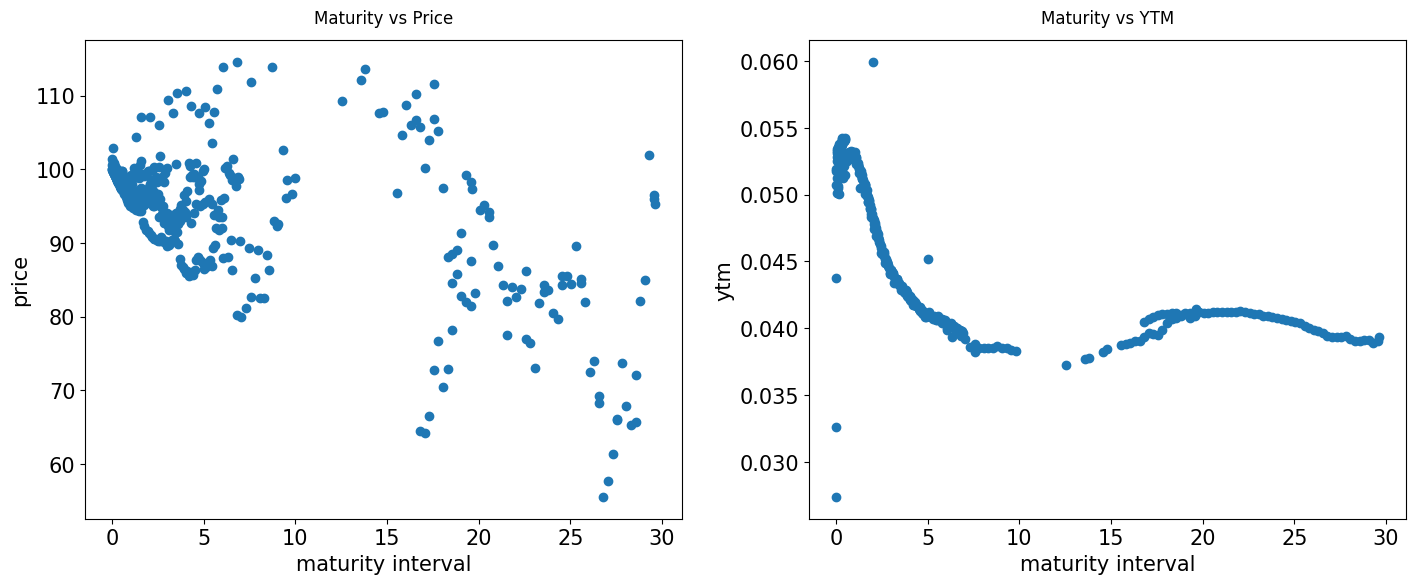

In [51]:
graphs = {'Maturity vs Price': (df['maturity interval'], df['price']), 'Maturity vs YTM' : (df['maturity interval'],df['ytm'])}

fig, (ax,ax2) = plt.subplots(ncols=2)
fig.tight_layout(pad=2)

axes = [ax, ax2]

for i, (key,value) in enumerate(graphs.items()):
    axes[i].scatter(value[0], value[1])
    axes[i].set_title(key, fontdict={'fontsize':12}, pad=12)
    axes[i].set_xlabel(value[0].name)
    axes[i].set_ylabel(value[1].name)

fig.set_figwidth(15)
plt.show()

> - The calculated rates are all relatively close to the provided YTM in the original source. 
> - The continuous rate is the closest to the original YTM. The slight difference may be attributed to the method used in calculating the price based on bid and ask prices.

### Q2: Extracting the Discount Curve

In [52]:
display(filter_cf)
CFset = {'all dates, including negative YTM quotes':filter_cf}
most_cf = filter_cf.sum(axis=0)
most_issues = filter_cf[filter_cf >0].count(axis = 0)
print(f'{most_cf.idxmax():%Y-%m-%d} has the most cashflow: {most_cf.max()} across all issues')
print(f'{most_issues.idxmax():%Y-%m-%d} has the most issues: {most_issues.max()} across all dates')

,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2051-09-15,2051-11-15,2052-02-15,2052-03-15,2052-05-15,2052-08-15,2052-09-15,2052-11-15,2053-02-15,2053-03-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207997,100,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
207231,0,101.3750,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
207742,0,100.0625,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
206998,0,100.6250,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
208025,0,0.0000,100,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207891,0,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,1.4375,0.0000,0.0000,101.4375,0.0000,0.0000,0,0.0000,0.0000
207934,0,0.0000,0,0,0,0,1.5000,0,0,0,...,0.0000,0.0000,1.5000,0.0000,0.0000,101.5000,0.0000,0,0.0000,0.0000
207977,0,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,2.0000,0.0000,0.0000,2.0000,0.0000,0.0000,102,0.0000,0.0000


2023-08-15 has the most cashflow: 517.6875 across all issues
2023-08-15 has the most issues: 76 across all dates


Bootstrap the discount factor.  
Starting with $C$ from the previous problem, further filter to create a subset of Treasury issues cashflow matrix $\tilde{C}$, such that each column has one, and only one, maturity. Also, each issue (row) has its face value payment in one of the columns.

,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2031-02-15,2031-05-15,2031-08-15,2031-11-15,2032-02-15,2032-05-15,2032-08-15,2032-11-15,2033-02-15,2033-05-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207997,100,0.000,0,0,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
207231,0,101.375,0,0,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
208025,0,0.000,100,0,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
207998,0,0.000,0,100,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
208034,0,0.000,0,0,100,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207889,0,0.000,0,0,0,0,0.000,0,0,0,...,0.000,1.4375,0.000,1.4375,0.000,101.4375,0.000,0.0000,0.00,0.0000
207932,0,0.000,0,0,0,0,1.375,0,0,0,...,1.375,0.0000,1.375,0.0000,1.375,0.0000,101.375,0.0000,0.00,0.0000
207975,0,0.000,0,0,0,0,0.000,0,0,0,...,0.000,2.0625,0.000,2.0625,0.000,2.0625,0.000,102.0625,0.00,0.0000


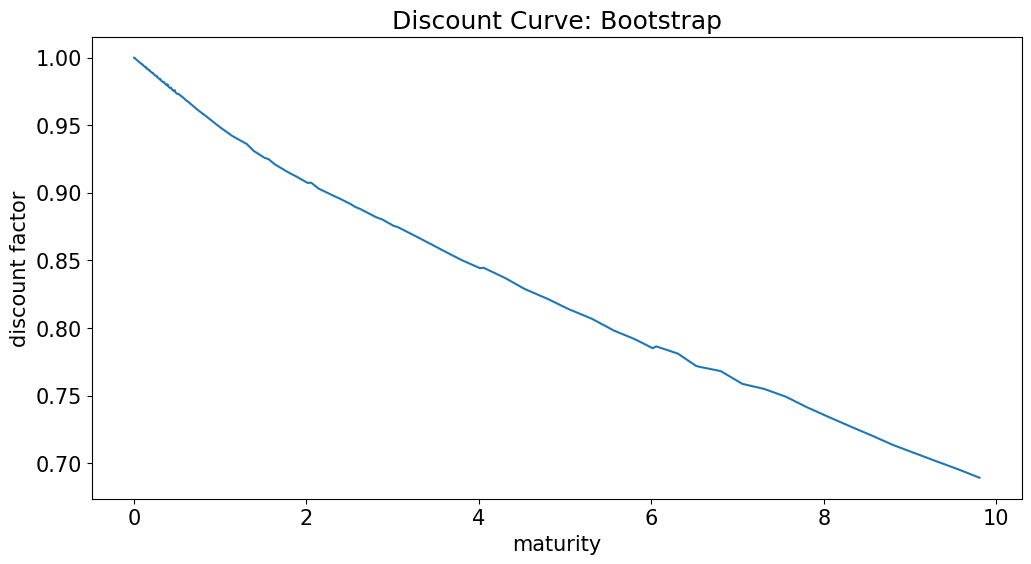

In [53]:
# STRICT BOOTSTRAPPING - 1 MATURITY ON EACH DATE. SQUARE MATRIX

strict_filter_data = filter_treasuries(rdata, t_date=t_current, drop_duplicate_maturities=True, filter_tips=True)
strict_filter_cf = filter_treasury_cashflows(calc_cashflows(strict_filter_data), filter_maturity_dates=True)
display(strict_filter_cf)
strict_price = metrics['price'][strict_filter_cf.index]
params_boot = estimate_rate_curve(bootstrap, strict_filter_cf, t_current, strict_price)
CFset['single maturity per date, no non-maturity dates'] = strict_filter_cf
plt.plot(params_boot[0],params_boot[1])
plt.xlabel('maturity')
plt.ylabel('discount factor')
plt.title('Discount Curve: Bootstrap')
plt.show()

,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2031-02-15,2031-05-15,2031-08-15,2031-11-15,2032-02-15,2032-05-15,2032-08-15,2032-11-15,2033-02-15,2033-05-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207997,100,0.0000,0,0,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
207231,0,101.3750,0,0,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
207742,0,100.0625,0,0,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
206998,0,100.6250,0,0,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
208025,0,0.0000,100,0,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207889,0,0.0000,0,0,0,0,0.000,0,0,0,...,0.000,1.4375,0.000,1.4375,0.000,101.4375,0.000,0.0000,0.00,0.0000
207932,0,0.0000,0,0,0,0,1.375,0,0,0,...,1.375,0.0000,1.375,0.0000,1.375,0.0000,101.375,0.0000,0.00,0.0000
207975,0,0.0000,0,0,0,0,0.000,0,0,0,...,0.000,2.0625,0.000,2.0625,0.000,2.0625,0.000,102.0625,0.00,0.0000


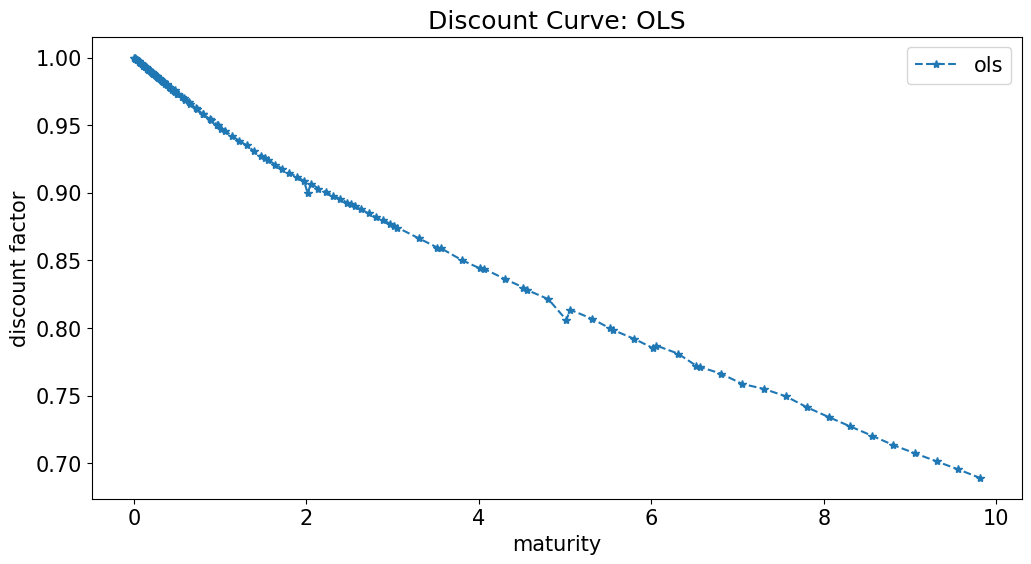

In [54]:
# ESTIMATE CURVE USING OLS
ols_filter_data = filter_treasuries(rdata, t_date=t_current, filter_tips=True, filter_yld=True)
ols_filter_cf = filter_treasury_cashflows(calc_cashflows(ols_filter_data), filter_maturity_dates=True)
display(ols_filter_cf)
ols_price = metrics['price'][ols_filter_cf.index]
params_ols = estimate_rate_curve(bootstrap, ols_filter_cf, t_current, ols_price)
CFset['multiple maturity per date, no non-maturity dates'] = ols_filter_cf
disc_ols = pd.DataFrame({'maturity':params_ols[0], 'ols': params_ols[1]}).set_index('maturity')
disc_ols.plot(marker='*',linestyle='--',ylabel='discount factor',title='Discount Curve: OLS')
plt.show()

### 4 Factors and Rates

Convert $\textbf{z}_{\text{bootstrap}}$ to a set of 
* continuous discount rates
* semiannually compounded discount rates


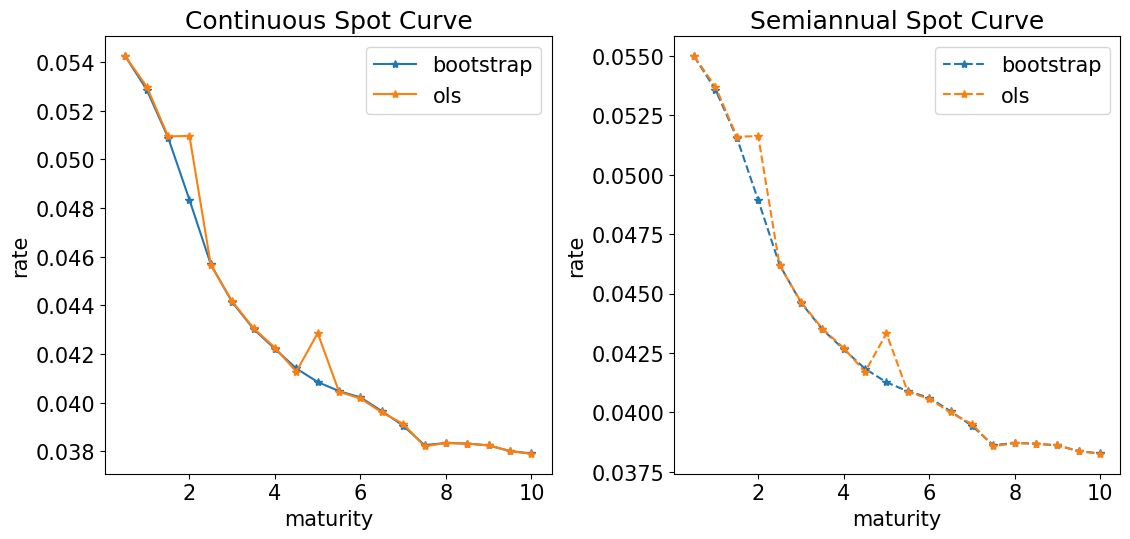

In [55]:
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=.01)

fig.tight_layout(pad=3)

axes = [ax, ax2]

inc = .5
maturity_grid = np.arange(inc,disc_ols.index.to_series().max()+.5,inc)

curves_ols = pd.DataFrame(index = maturity_grid)
curves_ols['bootstrap'] = bootstrap(params_boot,maturity_grid)
curves_ols['ols'] = bootstrap(params_ols,maturity_grid)

#semiannual compounding
semi = 2
curves_ols_semi = pd.DataFrame(index = maturity_grid)
curves_ols_semi['bootstrap'] = semi_bootstrap(params_boot,maturity_grid, semi)
curves_ols_semi['ols'] = semi_bootstrap(params_ols,maturity_grid, semi)

curves_ols.plot(linestyle='-',marker='*',ylabel='rate',xlabel='maturity', ax= ax, title='Continuous Spot Curve')
curves_ols_semi.plot(linestyle='--',marker='*',ylabel='rate',xlabel='maturity', ax = ax2, title='Semiannual Spot Curve')
plt.show()

,theta 0,theta 1,theta 2,lambda_1,theta_3,lambda_2
Nelson-Siegel,0.041537,0.020725,-0.032744,2.437959,None,None
Nelson-Siegel Extended,0.041354,0.035303,-0.043113,2.078893,-0.06557,0.135823


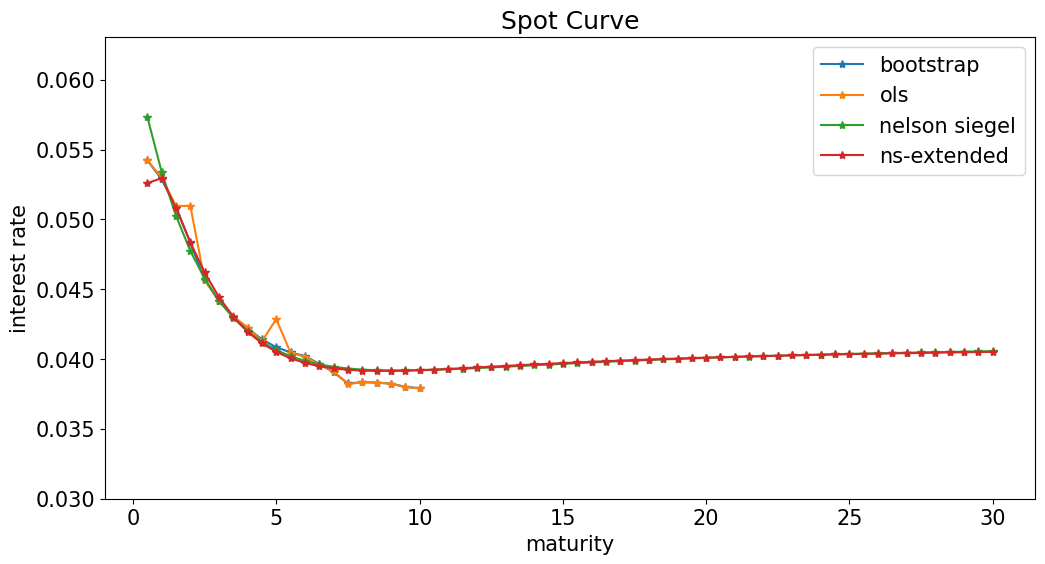

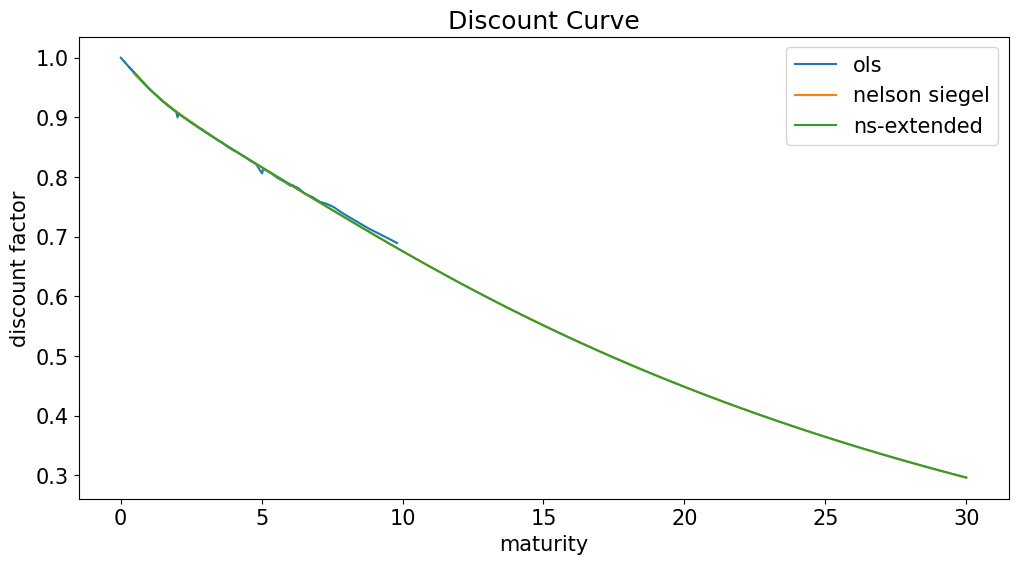

In [56]:
keys = list(CFset.keys())
CF = CFset[keys[0]]
prices = metrics['price'][CF.index]

x0 = np.ones(4)/10
params_NS = estimate_rate_curve(nelson_siegel,CF,t_current,prices,x0)

x0 = np.concatenate((params_NS,(1/10,1/10)))
params_NSE = estimate_rate_curve(nelson_siegel_extended,CF,t_current,prices,x0=x0)

tab_params_ns = pd.DataFrame(data = params_NS, index=['theta 0', 'theta 1', 'theta 2', 'lambda_1'],columns=['Nelson-Siegel']).T
tab_params_ns.loc[:,['theta_3', 'lambda_2']] = None
tab_params_ns.loc['Nelson-Siegel Extended',:] = params_NSE
display(tab_params_ns)

inc = .5

maturity_list = get_maturity_delta(list(CFset.values())[0].columns,t_current=t_current)
maturity_grid = np.arange(inc,maturity_list.max()+.5,inc)
curves = pd.DataFrame(index = maturity_grid)
curves['nelson siegel'] = nelson_siegel(params_NS,maturity_grid)
curves['ns-extended']= nelson_siegel_extended(params_NSE,maturity_grid)

ax = curves_ols.plot(linestyle='-',marker='*')
curves.plot(ax=ax, linestyle='-',marker='*', ylim=(.03,curves.max().max()*1.1))

series_plotted = list(curves_ols.columns) + list(curves.columns)
plt.legend(series_plotted)
plt.xlabel('maturity')
plt.ylabel('interest rate')
plt.title('Spot Curve')
plt.show()

params_ols = estimate_rate_curve(bootstrap,CF,t_current,prices)

ax = disc_ols.plot()

zero_curve = intrate_to_discount(curves.loc[:,'nelson siegel'], maturity_grid, n_compound=None).to_frame()
zero_curve['ns-extended'] = intrate_to_discount(curves.loc[:,'ns-extended'], maturity_grid, n_compound=None).to_frame()
zero_curve.plot(ax=ax, title='Discount Curve', xlabel='maturity',ylabel='discount factor')

plt.show()

# Homework 2

### Q1: HW Case A: YTM Spread Trade

Make a chart comparing the issues in the following features, (as of Nov 4, 2008.)
* coupon rate
* bid
* ask
* accrued interest
* dirty price
* duration (quoted in years, not days, assuming 365.25 days per year.)
* modified duration
* YTM

In [57]:
date = '2015-08-15'
filepath_tsdata = f'../data/treasury_ts_{date}.xlsx'
info = pd.read_excel(filepath_tsdata,sheet_name='info',index_col=0)
tsdata = pd.read_excel(filepath_tsdata,sheet_name='database')
tsdata.columns = tsdata.columns.str.upper()

In [58]:
date = '2008-11-04'
tab = get_table(info, tsdata, date)
tab

kytreasno,204046,204047
issue date,1985-08-15 00:00:00,2005-08-15 00:00:00
maturity date,2015-08-15 00:00:00,2015-08-15 00:00:00
coupon rate,10.625,4.25
type,bond,note
bid,141.859375,105.953125
ask,141.890625,105.984375
accrued interest,2.338655,0.935462
clean price,141.875,105.96875
dirty price,144.213655,106.904212
duration,5.230138,5.935706


### Long and Short ID

We long the bond with the higher YTM.

We short the bond with the lower YTM.

## 1.2 Hedge Ratio

Suppose you are building a trade to go long $n_i$ bonds (`204046`) and short $n_j$ notes (`204047`).


Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Suppose you will use \\$1mm of capital, leveraged 50x to buy \\$50mm of the bonds (`204046`).

Use the ratio above to short a number of notes (`204047`) to keep zero duration.

Report the number of bonds and notes of your position, along with the total dollars in the short position.

In [59]:
financing = pd.DataFrame(dtype='float64',index=['long','short'])

# Financing assumptions
financing['haircut'] = [.02,.02] #grants 50x leverage on both sides
financing['repo'] = [.0015,.0010] #15, 10 bps. interest for borrowing money on my leverage.
keyLong = tab.loc['ytm'].astype('float64').idxmax()
keyShort = tab.loc['ytm'].astype('float64').idxmin()

LONGEQUITY = 1e6

balsheet, fmt = trade_balance_sheet(prices=tab.loc['dirty price'], durations=tab.loc['duration'], 
                                    haircuts=financing['haircut'], long_equity=LONGEQUITY, 
                                    key_long=keyLong, key_short=keyShort)
display(balsheet.style.format(fmt,na_rep=''))

,equity,assets,contracts
204046,"$1,000,000.00","$50,000,000.00","346,707.81"
204047,"$-881,131.58","$-44,056,578.93","-412,112.66"


Profit ?? Using the concept of **modified duration**, how much profit or loss (PnL) would you expect to make for every basis point of convergence in the spread? Specifically, assume the convergence is symmetric: the bond's (`204046`) ytm goes down 0.5bp and the note (`204047`) ytm goes up 0.5bp.

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL? (This is just a linearly scaling of your prior answer for a 1bp convergence.) 

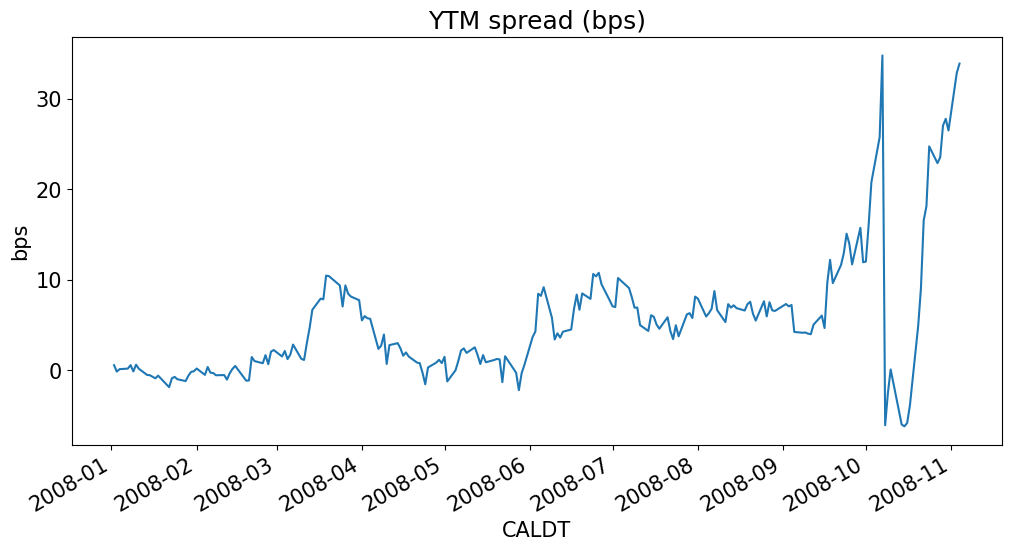

Spread converges:


,ytm change,modified duration,price,contracts,pnl
kytreasno,,,,,
204046,-0.1695%,5.14,$144.21,"346,707.81","$435,509.58"
204047,0.1695%,5.84,$106.90,"-412,112.66","$436,236.08"
total,,,,,"$871,745.67"


1 bp move:


,ytm change,modified duration,price,contracts,pnl
kytreasno,,,,,
204046,-0.0050%,5.14,$144.21,"346,707.81","$12,845.71"
204047,0.0050%,5.84,$106.90,"-412,112.66","$12,867.14"
total,,,,,"$25,712.85"


Opportunity summary:


,pnl,return
converges,"$871,745.67",46.34%
1bp,"$25,712.85",1.37%


In [60]:
spread = get_spread_bps(tsdata)
spread = spread[keyShort]
spread.rename('ytm spread (bps)',inplace=True)
spread.loc['2008':date].plot(ylabel='bps',title='YTM spread (bps)')
plt.show()


spread_convergence = tab.loc['ytm'].diff().dropna().abs().values[0]
pnl_spread_converges, fmt_dict = pnl_spread_trade(spread_convergence,tab.loc['modified duration'], 
                                                tab.loc['dirty price'], balsheet['contracts'])
print('Spread converges:')
display(pnl_spread_converges.style.format(fmt_dict,na_rep=''))

spread_convergence = .0001
pnl_spread_1bp, fmt_dict = pnl_spread_trade(spread_convergence,tab.loc['modified duration'], tab.loc['dirty price'], balsheet['contracts'])
print('1 bp move:')
display(pnl_spread_1bp.style.format(fmt_dict,na_rep=''))

opportunity = pd.DataFrame([pnl_spread_converges.loc['total','pnl'], pnl_spread_1bp.loc['total','pnl']], columns=['pnl'],index=['converges','1bp'])
opportunity['return'] = opportunity['pnl'] / balsheet['equity'].abs().sum()
print('Opportunity summary:')
display(opportunity.style.format({'return':'{:.2%}','pnl':'${:,.2f}'}))

Calculate the profit (or loss) on the position on the following two dates:
* 2008-11-25
* 2008-12-16

Does the pnl make sense (approximately) given your results in 1.3 with regard to the sensitivity of pnl to moves in the YTM spread?

In [61]:
ask = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK')
bid = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDBID')
accint = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDACCINT')
dirty = (ask + bid)/2 + accint
dirty = dirty[[keyLong,keyShort]]
duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN')[[keyLong,keyShort]] / 365.25

,price change,coupons,total pnl,ytm spread (bps)
2008-11-04 00:00:00,$0.00,$0.00,$0.00,33.88
2008-11-10 00:00:00,"$-115,883.84",$0.00,"$-115,883.84",38.54
2008-11-18 00:00:00,"$-181,887.02",$0.00,"$-181,887.02",41.15
2008-11-25 00:00:00,"$-499,072.82",$0.00,"$-499,072.82",52.96
2008-12-02 00:00:00,"$-748,066.35",$0.00,"$-748,066.35",61.46
2008-12-09 00:00:00,"$-903,774.22",$0.00,"$-903,774.22",67.29
2008-12-16 00:00:00,"$-1,049,332.75",$0.00,"$-1,049,332.75",71.61
2008-12-23 00:00:00,"$-805,707.20",$0.00,"$-805,707.20",63.50
2008-12-30 00:00:00,"$-756,986.09",$0.00,"$-756,986.09",61.81


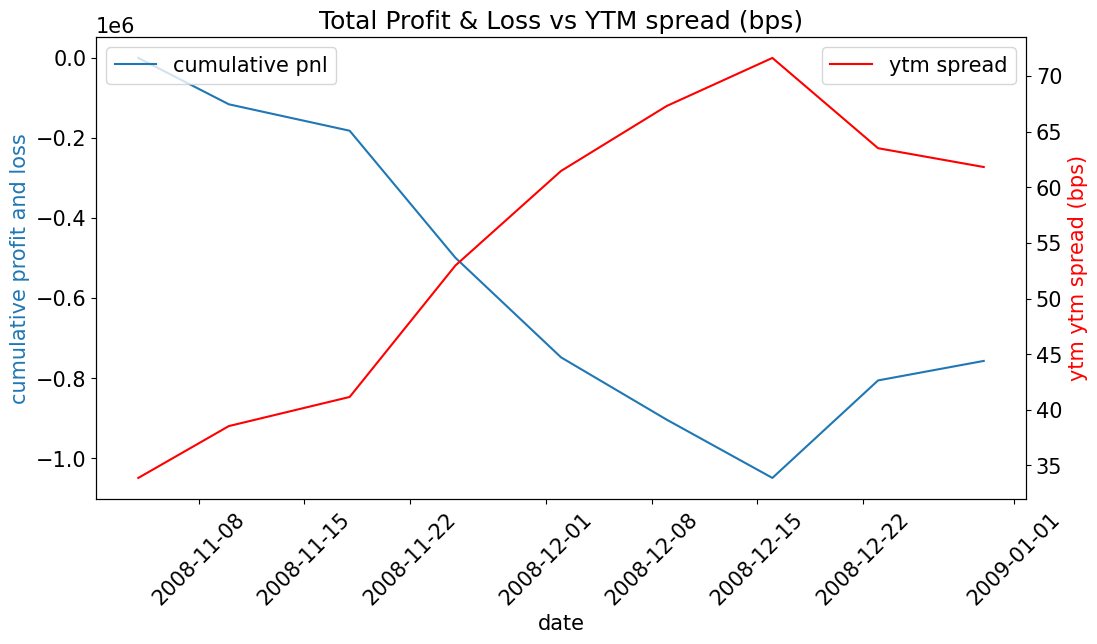

In [62]:
n_weeks = 9
trade, fmt_dict = trade_evolution(date, tab.loc['maturity date',keyShort], n_weeks, balsheet, 
                                dirty, duration, financing, tab.loc['coupon rate'], keyLong, keyShort)

summary = trade[['price change','coupons','total pnl']].join(spread,how='left')
fmt = fmt_dict
fmt['ytm spread (bps)'] = '{:.2f}'
display(summary.style.format(fmt,na_rep=''))
fig, ax = plt.subplots()

ax.plot(summary[['total pnl']])
ax.set_xlabel('date');
ax.set_ylabel('cumulative profit and loss',color=ax.get_lines()[-1].get_color())
ax.tick_params(axis='x', rotation=45)
ax.legend(['cumulative pnl'],loc=2)

ax2 = ax.twinx()
ax2.plot(summary[['ytm spread (bps)']], color='r')
ax2.set_ylabel('ytm ytm spread (bps)',color=ax2.get_lines()[-1].get_color())
ax2.legend(['ytm spread'],loc=1)

ax.set_title('Total Profit & Loss vs YTM spread (bps)')
plt.show()

Longer time horizon profit ?? 
Calculate the pnl of the trade for the following dates:
* 2009-01-27
* 2009-03-24
* 2009-06-16

Did the trade do well or poorly in the first six months of 2009?

Calculate the YTM spreads on these dates. Does the YTM spread correspond to pnl roughly as we would expect based on the calculation in 1.3?

,price change,coupons,total pnl,ytm spread (bps)
2008-11-04 00:00:00,$0.00,$0.00,$0.00,33.88
2008-12-02 00:00:00,"$-748,066.35",$0.00,"$-748,066.35",61.46
2008-12-30 00:00:00,"$-756,986.09",$0.00,"$-756,986.09",61.81
2009-01-27 00:00:00,"$20,657.36",$0.00,"$20,657.36",35.33
2009-02-24 00:00:00,"$-561,855.73","$966,145.83","$404,290.09",22.07
2009-03-24 00:00:00,"$-545,508.23","$966,145.83","$420,637.60",22.02
2009-04-21 00:00:00,"$-222,863.63","$966,145.83","$743,282.19",10.41
2009-05-19 00:00:00,"$22,192.58","$966,145.83","$988,338.41",1.32
2009-06-16 00:00:00,"$234,164.91","$966,145.83","$1,200,310.74",-7.14


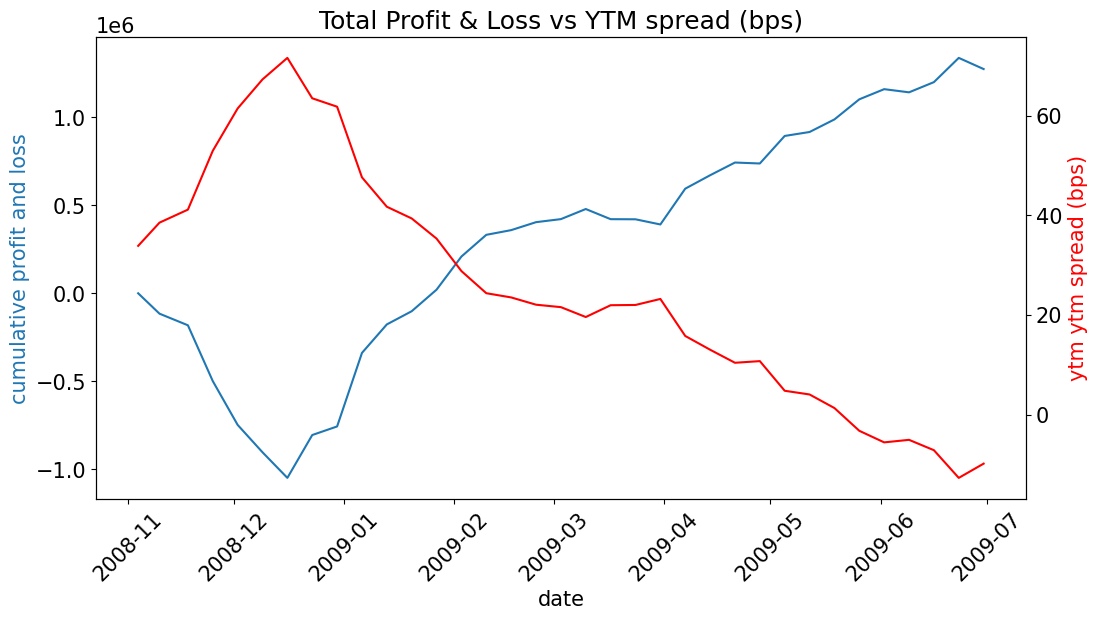

In [63]:
n_weeks = 35
trade_long, fmt_dict = trade_evolution(date, tab.loc['maturity date',keyShort], n_weeks, 
                                    balsheet, dirty, duration, financing, tab.loc['coupon rate'], keyLong, keyShort)

summary_long = trade_long[['price change','coupons','total pnl']].join(spread,how='left')
fmt = fmt_dict
fmt['ytm spread (bps)'] = '{:.2f}'
display(summary_long.iloc[::4,:].style.format(fmt,na_rep=''))

fig, ax = plt.subplots()

ax.plot(summary_long[['total pnl']])
ax.set_xlabel('date');
ax.set_ylabel('cumulative profit and loss',color=ax.get_lines()[-1].get_color())
ax.tick_params(axis='x', rotation=45)

ax2 = ax.twinx()
ax2.plot(summary_long[['ytm spread (bps)']], color='r')
ax2.set_ylabel('ytm ytm spread (bps)',color=ax2.get_lines()[-1].get_color())

ax.set_title('Total Profit & Loss vs YTM spread (bps)')
plt.show()

# Q2: Hedging Duration

In [64]:
filepath_tsdata = '../data/treasury_ts_issue_duration_(207392, 207391, 207404).xlsx'
info = pd.read_excel(filepath_tsdata,sheet_name='info').set_index('kytreasno')
SIZE = 10000
IDLONG = 207391
IDSHORT = 207392
FREQ = 365.25
tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')
tsdata.columns = tsdata.columns.str.upper()
px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()
duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()/FREQ


Suppose you have a portfolio of 10,000 USD long in security `207391` on the last day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in `207392`?

(Duration is the column `TDDURATN` in the raw data.)



Step through the time-series, doing the following:

* Starting at the end of the first day, set the hedged position according to the relative given durations.
* Use the second day's price data to evaluate the net profit or loss of the hedged position.
* Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security `207391` to be 10,000.
* Repeat throughout the timeseries.

Report 
* the total profit (or loss.)
* the mean, standard deviation, min, and max of the daily profit or loss.

Verify hedged:


,count,mean,std,min,25%,50%,75%,max
duration,106700.0%,-0.0%,0.0%,-0.0%,-0.0%,0.0%,0.0%,0.0%


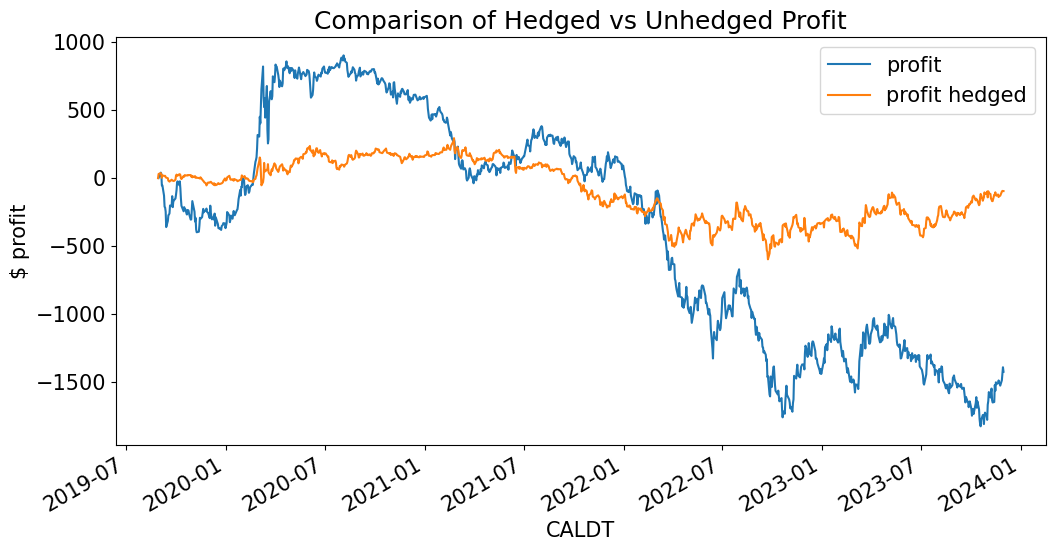

,profit,profit hedged
mean,$-1.34,$-0.09
std,$46.97,$21.78
min,$-321.11,$-98.32
25%,$-29.54,$-11.98
50%,$-2.40,$-0.44
75%,$25.43,$10.41
max,$276.19,$119.78


In [65]:
position = pd.DataFrame(index=duration.index, dtype=float)

position['long'] = SIZE / px[IDLONG]
position['hedge ratio'] = (duration[IDLONG] / duration[IDSHORT]) * (px[IDLONG] / px[IDSHORT]) #dollar duration is duration * price
position['short'] = - position['hedge ratio'] * position['long']
position[['long ($)','short ($)']] = position[['long','short']] * px[[IDLONG,IDSHORT]].values
position['net ($)'] = position[['long ($)','short ($)']].sum(axis=1)
wts = position[['long ($)','short ($)']].div(position[['long ($)','short ($)']].sum(axis=1),axis=0)
position['duration'] = (wts * duration[[IDLONG,IDSHORT]].values).sum(axis=1)

print('Verify hedged:')
display(position['duration'].describe().to_frame().T.style.format('{:.1%}'))
position[['long ($) realized','short ($) realized']] = position[['long','short']] * px[[IDLONG,IDSHORT]].shift(-1).values
position[['long p&l','short p&l']] = position[['long ($) realized','short ($) realized']] - position[['long ($)','short ($)']].values
position['profit hedged'] = position[['long p&l','short p&l']].sum(axis=1)
position['profit'] = px[IDLONG].diff() * position['long'].shift()
position[['profit','profit hedged']].cumsum().plot(ylabel = '$ profit', title = 'Comparison of Hedged vs Unhedged Profit')
plt.show()
display(position[['profit','profit hedged']].describe().drop(index=['count']).style.format('${:,.2f}'))

### Q3: calculating duration via individual cashflows (extra)
### Q4: level slope curvature and factor duration (extra)
see solutions for both of these if needed

# Homework 3

## HBS Case (C) Spread and Swap Spread in November 2008

### Duration Quotes
Bond
* Quote: Val01 of bond is .1746 per bp per \$1 face value
* Class terminology: Modified dollar duration is .1746 per \$100 face value

Swap
* Quote: DV01 of swap is 1.7mm per 1 billion notional.
* Class terminology: Modified dollar duration is 100(1.7/1000) per \$100 face value.




### Maturity Mismatch

The maturity of the bond is August 2038, whereas the date is Nov 2008. Thus, the bond has less than 30 years to maturity, yet he is entering a 30-year swap. 

For simplicity, we imagine the bond is issued in Nov 2008 and thus has maturity of 30 years at the time of the case.

However, then the case quotes for the Nov price and YTM of the bond no longer are accurate. Use one and adjust the other. Namely, we could...
    * use the Nov 4 **YTM** quoted in the case, and re-adjust the the bond.
    * use the Nov 4 **price** quoted in the case, and re-adjust the YTM.
    
We do the former, keep the quoted YTM, assume time-to-maturity of `30`, and recalculate the Nov 2008 price. (It is close to the quoted price in the case.)

In [66]:
USE_PAR_TBOND = False
# Set coupon on 30-year T bond to equal Nov 4 YTM
# Or stick with the coupon rate in the case, for the Aug 2008 T bond

YTM = [0.04193, .0436]

if USE_PAR_TBOND:
    CPNRATE = [YTM[0], .0436]
else:
    CPNRATE = [0.0450, .0436]

SWAPRATE = [.042560, .0408]

TPRICE = 105
PAR = 100

NOTIONAL = 500e6
HAIRCUT = .02

DTIME = .5
tau0 = 30
tau1 = tau0-DTIME

In [67]:
# Define market environment:
summary = pd.DataFrame(index=['coupon rate','YTM','swap rate','spread'],columns = ['Nov 2008','May 2009'],dtype=float)
summary.loc['coupon rate'] = CPNRATE
summary.loc['YTM'] = YTM
summary.loc['swap rate'] = SWAPRATE
summary.loc['YTM spread'] = summary.loc['swap rate'] - summary.loc['YTM']
summary.loc['coupon spread'] = summary.loc['swap rate'] - summary.loc['coupon rate']
summary.style.format('{:.2%}')

,Nov 2008,May 2009
coupon rate,4.50%,4.36%
YTM,4.19%,4.36%
swap rate,4.26%,4.08%
spread,nan%,nan%
YTM spread,0.06%,-0.28%
coupon spread,-0.24%,-0.28%



Report the price of the 30-year T-bond in Nov 2008. Given the discussion about `Maturity Mismatch`, we are repricing the bond, so it will not exactly equal `105` as reported in the case.

In [68]:
bond_price = price_treasury_ytm(tau0, YTM[0], CPNRATE[0], freq=2, face=PAR)
bond_price

105.21328175314193

List the projected cashflows on May 4, 2009, exactly six months into the trade, on the first coupon and swap date.

In [69]:
SOFR = np.nan
CF = pd.DataFrame(index=['T bond','Repo','Swap (floating leg)','Swap (fixed leg)'],columns=['May 2009'],dtype=float)
CF.loc['Repo'] -SOFR
CF.loc['Swap (floating leg)'] = SOFR
CF.loc[['T bond']] = PAR * CPNRATE[0] /2
CF.loc[['Swap (fixed leg)']] = -PAR * SWAPRATE[0]/2
CF.loc['Net Payment'] = CF.sum(axis=0)
CF.style.format('${:,.2f}')

,May 2009
T bond,$2.25
Repo,$nan
Swap (floating leg),$nan
Swap (fixed leg),$-2.13
Net Payment,$0.12


What is the duration of...
* the T-bond
* the swap

Remember that...
* the swap can be decomposed into a fixed-rate bond and a floating-rate note
* a floating-rate note has duration equal to the time until the next reset. Thus, at initialization, it has duration equal to 0.5 years.

Is the duration for the "paying-fixed" swap positive or negative? Is it bigger or smaller in magnitude than the T-bond?

For this problem, calculate the Macauley duration and the dollar (Macauley) duration.

In [70]:
tab_duration = pd.DataFrame(dtype=float, index=['T bond','fixed leg', 'floating leg'], columns=['duration'])
tab_duration.loc['T bond'] = duration_closed_formula(30, summary.loc['YTM','Nov 2008'], summary.loc['coupon rate','Nov 2008'])
tab_duration.loc['fixed leg'] = duration_closed_formula(30, summary.loc['swap rate','Nov 2008'])
tab_duration.loc['floating leg'] = .5
tab_duration['dollar duration'] = tab_duration['duration'] * np.array([bond_price, PAR, PAR])
tab_duration.loc['swap'] = tab_duration.loc['fixed leg'] - tab_duration.loc['floating leg']
tab_duration.loc['net'] = tab_duration.loc['T bond'] - tab_duration.loc['swap']
tab_duration

,duration,dollar duration
T bond,17.083633,1797.425100
fixed leg,17.212744,1721.274445
floating leg,0.500000,50.000000
swap,16.712744,1671.274445
net,0.370889,126.150654



What hedge ratio should be used to balance the notional size of the Treasury bond with the notional size of the swap, such that it is a duration-neutral position?

Specifically, if the trader enters the swap paying fixed on \$500 million notional, how large of a position should they take in the Treasury bond?

In [86]:
hedge_ratio = tab_duration.loc['swap','dollar duration'] / tab_duration.loc['T bond','dollar duration']
contracts = pd.DataFrame(NOTIONAL * np.array([hedge_ratio/PAR, -1/PAR]), index=['T bond','swap'], columns=['positions'])
contracts

,positions
T bond,4.649080e+06
swap,-5.000000e+06


Suppose it is May 4, 2009, exactly six months after putting the trade on.

The spread is at -28 bps due to...
* The YTM on a new 30-year bond has risen to 4.36\%
* The swap rate on a new 30-year swap has dropped to 4.08\%

Explain conceptually how this movement impacts the components of the trade.

> - Rising YTM of the bond indicates a lower price of the T-bond, and since we are long the bond in this trade, this is a loss.
> - Lower swap reate suggests higher value of the fixed leg of a swap, and since we are paying fixed (short fixed leg) this is also a loss.
> - Floating leg of the swap and repo rate cancel


Calculate the value of the position on May 4, 2009, immediately after the first coupon and swap payments and swap reset. 

* Calculate the revised price of the Treasury bond by assuming you can apply the (May 4) 30-year YTM as a discount rate to the 29.5 year bond. (We are just using this for a rough approximation. You know that good pricing would require a discount curve, but let's not get bogged down with that here.)


* Calculate the value of the swap by decomposing it into a fixed-rate bond and a floating-rate bond.
    * The 29.5 year fixed-rate leg is priced using the (May 4) 30-year swap rate as a discount rate.
    * The floating-rate leg is priced at par given that floating-rate notes are par immediately after resets.


In [87]:
prices = pd.DataFrame(index=['T bond', 'swap'],dtype=float,columns=['Nov 2008'])

if USE_PAR_TBOND:
    prices.loc['T bond','Nov 2008'] = price_treasury_ytm(tau0, summary.loc['YTM','Nov 2008'], summary.loc['coupon rate','Nov 2008'])
else:
    prices.loc['T bond','Nov 2008'] = bond_price

prices.loc['swap','Nov 2008'] = PAR - PAR

prices.loc['T bond','May 2009'] = price_treasury_ytm(tau1, summary.loc['YTM','May 2009'], summary.loc['coupon rate','Nov 2008'])
prices.loc['swap','May 2009'] = price_treasury_ytm(tau1, summary.loc['swap rate','May 2009'], summary.loc['swap rate','Nov 2008']) - PAR

prices.style.format('${:,.2f}')

,Nov 2008,May 2009
T bond,$105.21,$102.31
swap,$0.00,$3.00



Accounting for the change in value of the positions, as well as the 6-month cashflows paid on May 4, 
* what is the net profit and loss (pnl) of the position?
* what is the return on the equity capital, considering that there was a 2\% haircut (equity contribution) on the size of the initial treasury bond position.

In [88]:
pnl=pd.DataFrame(dtype=float,index=['T bond','swap'],columns=['cashflow'])

pnl['cashflow'] = CF.loc[['T bond','Swap (fixed leg)']].values * contracts.abs().values
pnl['capital gains'] = prices.diff(axis=1)['May 2009'].values * contracts.values[:,0]

pnl.loc['net'] = pnl.sum()

pnl['total'] = pnl.sum(axis=1)

display(pnl.style.format('${:,.2f}',na_rep=''))

capital = pd.DataFrame(prices.iloc[:,0].values * contracts.values[:,0], index=['T bond','swap'],columns=['assets'])
capital['equity'] = capital['assets'] * HAIRCUT
capital.loc['net'] = capital.sum()

capital['pnl'] = pnl['total']
capital['return'] = capital['pnl']/capital['equity']
capital.loc[['T bond','swap'],'return'] = np.nan

capital.style.format({'assets':'${:,.2f}','equity':'${:,.2f}','pnl':'${:,.2f}','return':'{:.2%}'},na_rep='')

,cashflow,capital gains,total
T bond,"$10,460,428.93","$-13,491,075.85","$-3,030,646.92"
swap,"$-10,640,000.00","$-15,016,747.03","$-25,656,747.03"
net,"$-179,571.07","$-28,507,822.87","$-28,687,393.94"


,assets,equity,pnl,return
T bond,"$489,144,913.92","$9,782,898.28","$-3,030,646.92",
swap,$-0.00,$-0.00,"$-25,656,747.03",
net,"$489,144,913.92","$9,782,898.28","$-28,687,393.94",-293.24%


# Homework 4: Information Content of the Yield Curve

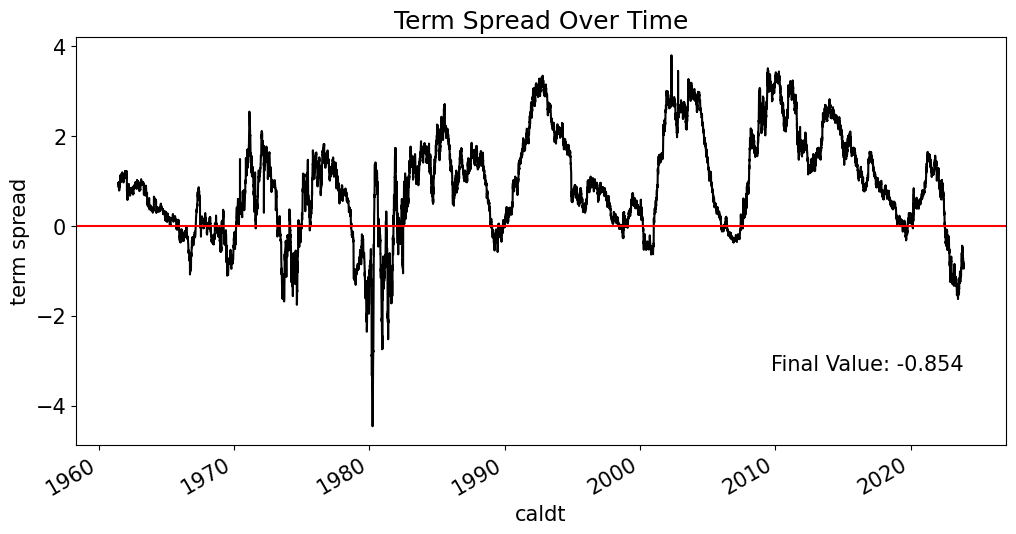

In [99]:
filepath = f'../data/yields.xlsx'
yields = pd.read_excel(filepath, index_col=0, parse_dates=True)

# Calculate the term spread
# 10 yr yield - 1 yr yield
term_spread = yields[10] - yields[1]
ax = term_spread.plot(color='k')
ax.axhline(0, color='r')

# Add label for final value
final_value = term_spread.iloc[-1]

ax.annotate(f'Final Value: {final_value:.3f}', xy=(term_spread.index[-1], -4), xytext=(term_spread.index[-1], final_value - 2), ha='right', va='top')
ax.set_xlabel('caldt')
ax.set_ylabel('term spread')
ax.set_title('Term Spread Over Time')
plt.show()

# Q1 Heuristic
# Q2 Calculating Forwards

In [100]:
QUOTE_DATE = '2023-08-31'
filepath = f'../data/select_maturities_{QUOTE_DATE}.xlsx'
quotes = pd.read_excel(filepath, index_col=0)
t_date = pd.to_datetime(QUOTE_DATE)

Bootstrap the discount factor. 

Plot the answer in terms of discount factors and discount rates.

#### Simplification 
Though the time-to-maturity (ttm) is not spaced exactly at 6 months, for the purposes of this problem, you are welcome to approximate that they are spaced at exact 6-month intervals.

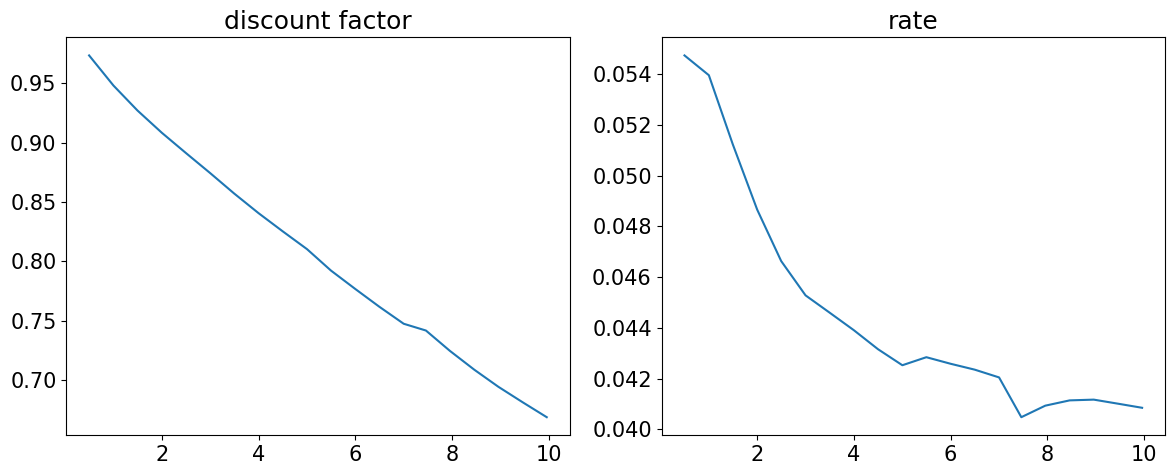

In [118]:
COMPOUNDING = 2

spot = pd.DataFrame(bootstrap_spot_rates(quotes))
spot.columns = ['rate']
spot['discount factor'] = intrate_to_discount(spot['rate'],spot.index,n_compound=COMPOUNDING)
#Plot discount factor and rate
fig, ax = plt.subplots(1,2,figsize=(12,5))
spot['discount factor'].plot(ax=ax[0],title='discount factor')
spot['rate'].plot(ax=ax[1],title='rate')
plt.tight_layout()
plt.show()

In [101]:
# BUILD CF MATRIX
CF = pd.DataFrame(0, index=quotes.index, columns= quotes['maturity date'])
for i in quotes.index:
    coupon_dates = get_coupon_dates(t_date, pd.to_datetime(quotes.loc[i, 'maturity date']))
    if coupon_dates is not None:
        CF.loc[i, coupon_dates] = quotes.loc[i, 'cpn rate'] / 2    
    CF.loc[i,quotes.loc[i, 'maturity date']] += 100

CF = CF.resample('m', axis = 1).sum()
CF.drop(columns=CF.columns[(CF==0).all()], inplace=True)
CF = CF.fillna(0).sort_index(axis=1)

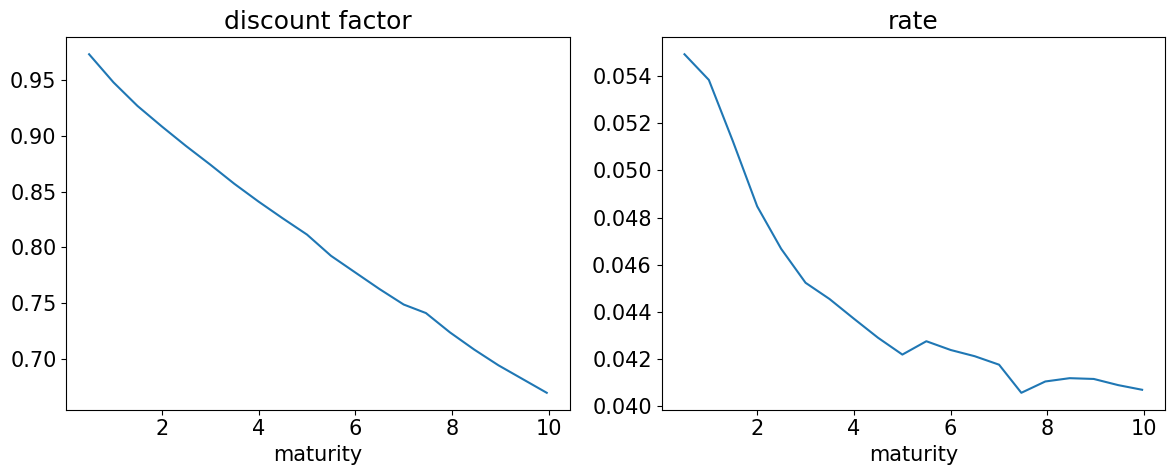

In [103]:
COMPOUNDING = 2
quotes['price'] = (quotes['bid'] + quotes['ask']) / 2 + quotes['accrint']
quotes['maturity'] = get_maturity_delta(quotes['maturity date'], t_date)

spot = pd.DataFrame(np.linalg.solve(CF,quotes['price'].loc[CF.index]), index=CF.index, columns=['discount factor'])
spot.insert(0,'maturity',quotes['maturity'])
spot = spot.reset_index().set_index('maturity')
spot['rate'] = discount_to_intrate(spot['discount factor'], spot.index,n_compound=COMPOUNDING)

#Plot discount factor and rate
fig, ax = plt.subplots(1,2,figsize=(12,5))
spot['discount factor'].plot(ax=ax[0],title='discount factor')
spot['rate'].plot(ax=ax[1],title='rate')
plt.tight_layout()
plt.show()


## 2.2
Calculate and plot the forward discount factors from $T$ to $T+0.5$, ranging $T$ from 0.5 through 9.5.



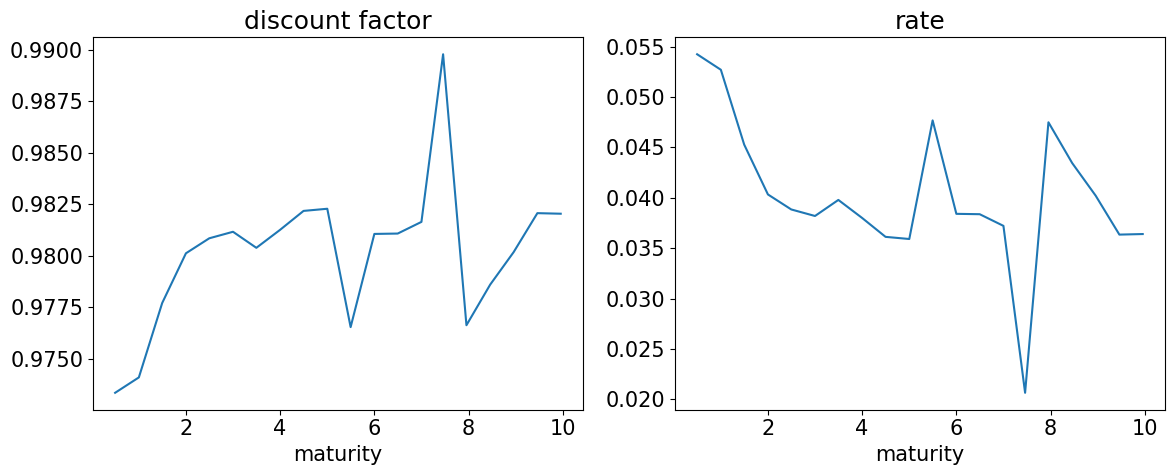

In [113]:
FORWARD_INTERVAL = 1

forward = pd.DataFrame(spot['discount factor']/spot['discount factor'].shift(FORWARD_INTERVAL),index=spot.index, columns=['discount factor'])
forward['discount factor'].iloc[FORWARD_INTERVAL-1] = spot['discount factor'].iloc[FORWARD_INTERVAL-1]
forward['rate'] = -np.log(forward['discount factor']) / forward.index.to_series().diff(FORWARD_INTERVAL).mean()
fig, ax = plt.subplots(1,2,figsize=(12,5))
forward['discount factor'].plot(ax=ax[0],title='discount factor')
forward['rate'].plot(ax=ax[1],title='rate')
plt.tight_layout()
plt.show()


## 2.3
Use the forward discount factors to calculate the `semiannually` compounded forward **rates**.

Plot the curve.

Also report the forward-rate values from 

* $T_1=0.5$ to $T_2=1$.
* $T_1=9.5$ to $T_2=10$.

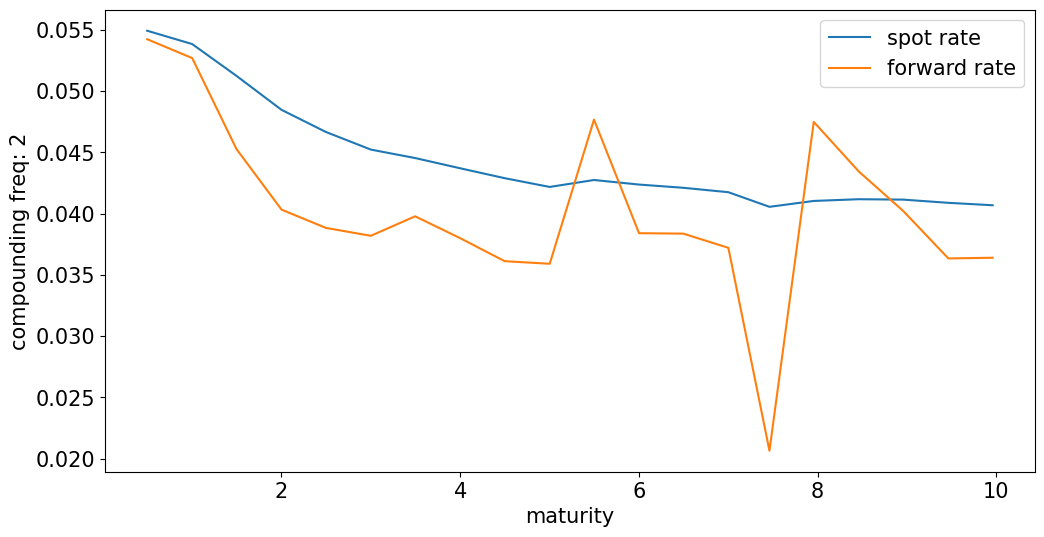

The Forward Rate at 0.5 to 1 is 5.27%
The Forward Rate at 9.5 to 10 is 3.64%


In [114]:
fig, ax = plt.subplots()
spot['rate'].plot(ax=ax)
forward['rate'].plot(ax=ax)
plt.legend(['spot rate','forward rate'])
plt.ylabel(f'compounding freq: {COMPOUNDING}')
plt.show()
T2list = [1,10]
for T2 in T2list:
    forwardrate = forward['rate'].iloc[int(T2*2)-1]
    print(f'The Forward Rate at {T2-.5} to {T2} is {forwardrate:.2%}')

### How would an FRA between T1 and T2 Function?

The FRA would have contract parameters for

- Notional
- T1 and T2 dates
- floating rate index paid to the counterparty

Given these parameters, counterparties would agree upon forward rate for exchange of payment:
\begin{align*}
N\kappa[r_n(T_1,T_2)-f_n(t,T_1,T_2)]
\end{align*}
where $\kappa$ is the fraction of the year covered by $T_2-T_1$ and $N$ is the notional amt.

We calculated this fixed forward rate above, assuming $T_2 = T_1 + .5$



# Homework 5

In [119]:
date = '2023-12-29'
filepath = f'../data/famabliss_strips_{date}.xlsx'
prices = pd.read_excel(filepath, sheet_name='prices')
prices.set_index('date',inplace=True)
prices.columns = prices.columns.astype(int)
prices = prices/100
prices.head()

,1,2,3,4,5
date,,,,,
1952-06-30,0.981778,0.962531,0.942467,0.926341,0.904183
1952-07-31,0.980948,0.960315,0.939312,0.923089,0.898516
1952-08-29,0.980578,0.959750,0.937819,0.921458,0.895717
1952-09-30,0.980312,0.959098,0.937551,0.920961,0.891676
1952-10-31,0.981108,0.959745,0.937583,0.919290,0.897248


## 1.1

For each of the six dates, (Dec 2018, Dec 2019, ...), calculate the forward discount factor, $F(t,T_1,T_2)$, where $T_2 = T_1 + 1$ for $1\le T_1\le 4$.

Make a plot of the curve $F$ at each of these six dates.

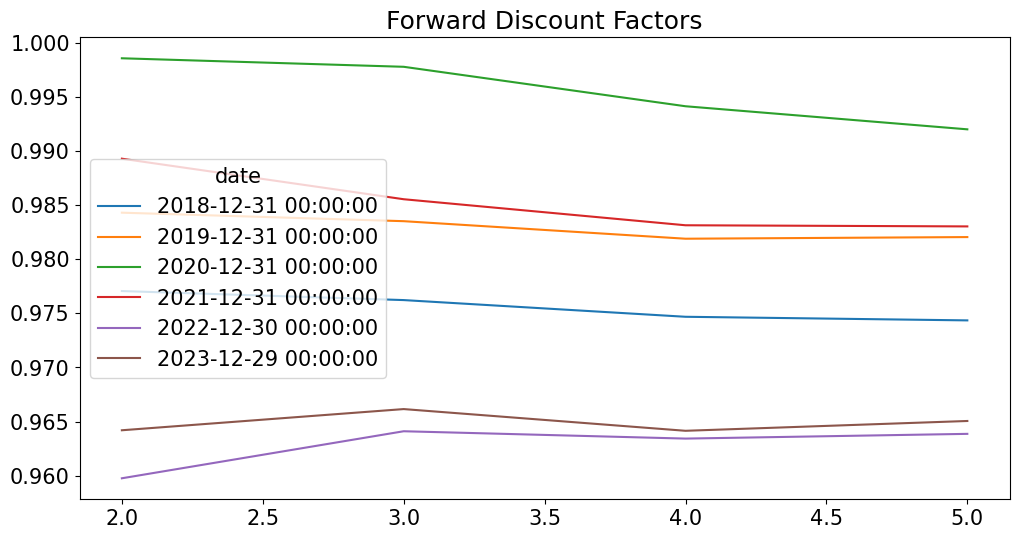

In [121]:
px = prices.iloc[-61::12]
F = px[[2,3,4,5]] / px[[1,2,3,4]].values
F.T.plot(title = 'Forward Discount Factors')
plt.show()

Use $F$ above to calculate the continuously compounded forward rates, $f$, at the six dates.

Make a plot of the curve, $f$, at each of these six dates.

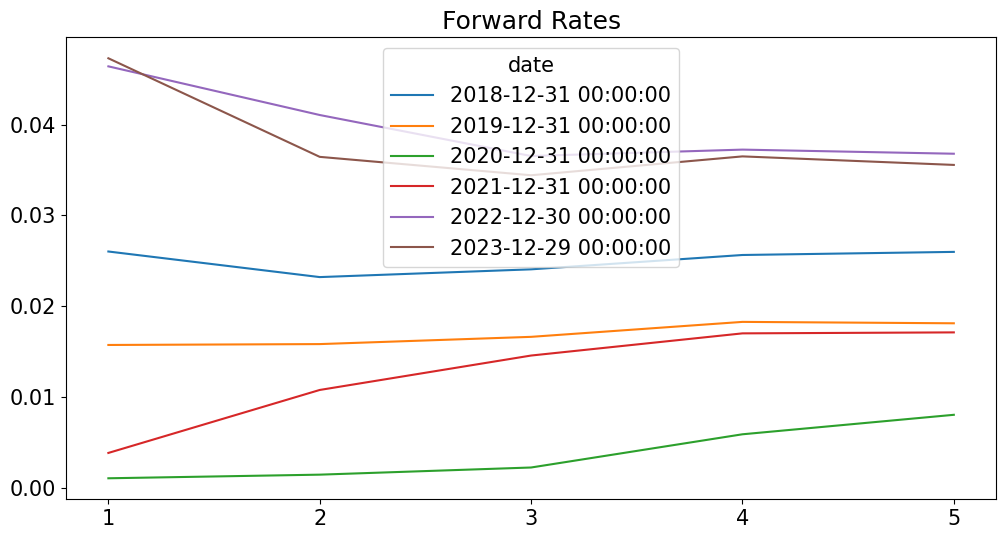

In [123]:
spots = -np.log(px)/ px.columns
f = -np.log(F)
f.insert(0,1, spots[1])
f.T.plot(title = 'Forward Rates', xticks = f.columns)
plt.show()



Calculate the continuously compounded spot rates, $r$, at the six dates.

Plot both the forward curve and the spot curve on the date of Dec 2018.

Recall that $f(t,t,t+1) = r(t,t+1)$.

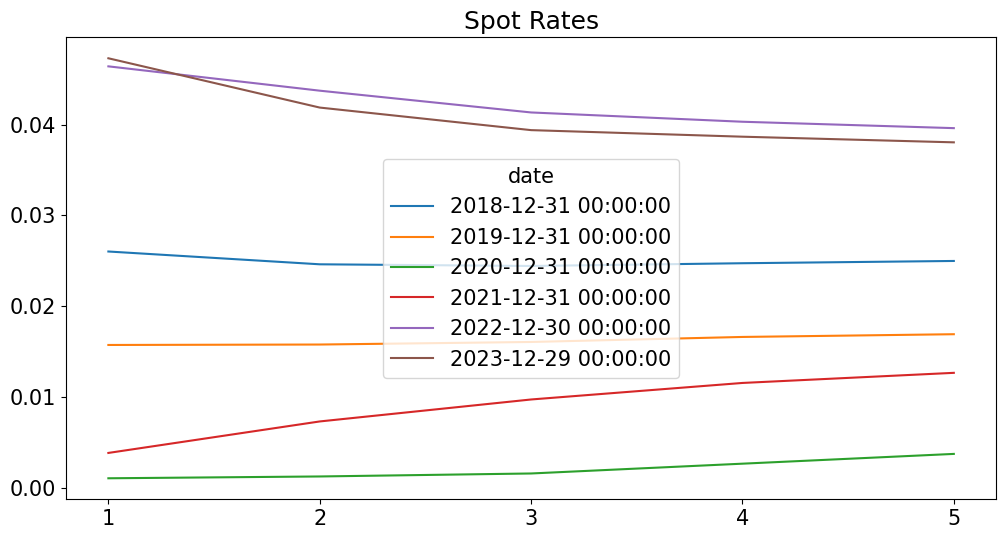

In [124]:
DATE = '2018'
spots.T.plot(title = 'Spot Rates', xticks = spots.columns)
plt.show()

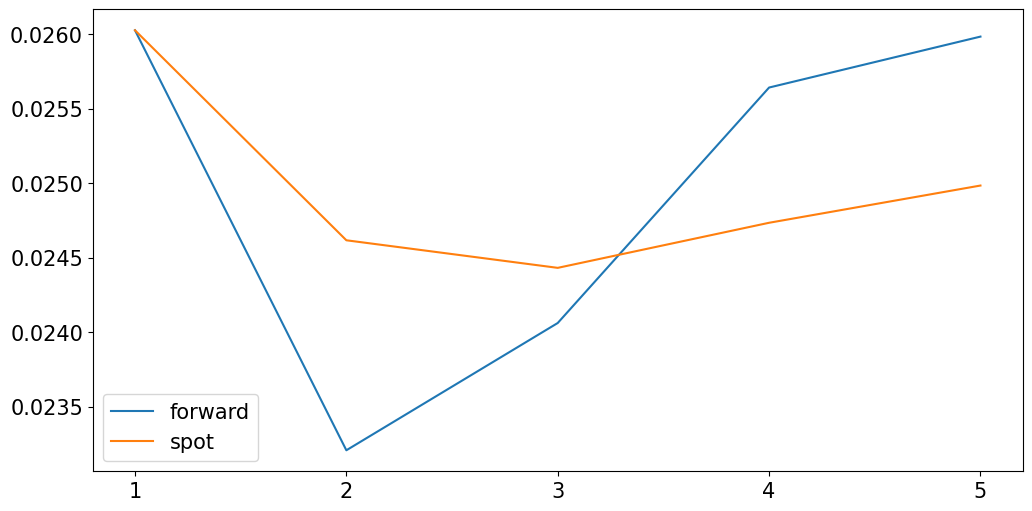

In [125]:
ax = f.loc[DATE].T.plot(xticks=f.columns)
spots.loc[DATE].T.plot(ax=ax)
ax.legend(['forward','spot'])
plt.show()

> The forward curve is below the spot curve for the first 3 years so the spot curve is downward sloping, but after that the forward curve is above the spot curve so it is upward sloping


Plot the forward curve on Dec 2018 against the time-series evolution of $r(t,t+1)$ for dates $t$ between Dec 2018 and Dec 2022.

How does the evolution of one-year rates between 2018-2022 compare to the forward rates of 2018?

In [126]:
temp = f.loc[DATE].T

temp.columns.name = f'{DATE}: (n-1) to n'
temp.columns = [f'forward curve']
temp['spot over time'] = spots[1].values[:-1]
temp

,forward curve,spot over time
1,0.026026,0.026026
2,0.023207,0.015729
3,0.024061,0.001042
4,0.025642,0.003834
5,0.025984,0.046425


The realized one-year spot rates over 2019-2021 are much lower than what was implied by the 2018 forward curve---with the exception of the realized spot in 2022 (at year 5) being higher than the forward rate implication.

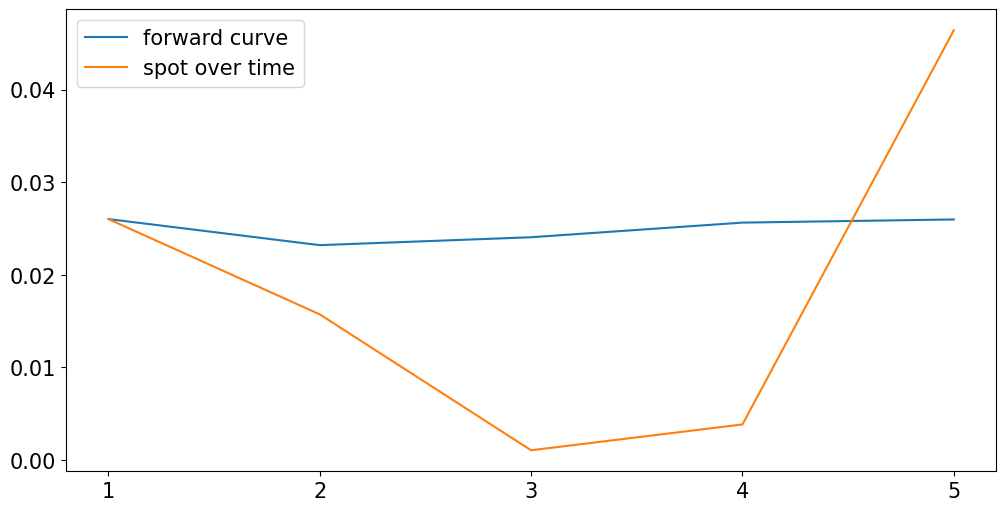

In [129]:
ax = temp.plot(xticks=temp.index)

# Q2: Carry Trade


Suppose it is December 2018, and you determine to implement a carry trade with the following specification...

* Long \\$100 million (market value, not face value) of the 5-year zero-coupon bond (maturing Dec 2023.)
* Short \\$100 million (market value, not face value) of the 1-year zero-coupon bond (maturing Dec 2019.)
* Assume there is a 2% haircut on each side of the trade, so it requires \\$4 million of investor capital to initiate it.

1. Calculate the total profit and loss year-by-year.
1. Calculate the total return (Dec 2023) on the initial \\$4 million of investor capital.

#### Short position
* Each year you will roll over the short position to maintain a short \\$100 million (market value) in the 1-year bond.
* This will require injecting more cash into the trade, as the expiring short will require more than \$100 million to close out. 
* In Dec 2022, no need to open a new short position, as your long position will (at that point) be a one-year bond.

#### Alternatives
The scheme above is for simplicity. You could try more interesting ways of setting the short position...
* Open a new short position sized to whatever is needed to cover the expiring short position.
* Set the short positions to duration-hedge the long position.

In [130]:
# Parameters
HAIRCUT = .02
INIT_SIZE = 1e8
FACE = 1e6

p = px.copy()
p.insert(0,'cash',1)
p *= FACE

In [131]:
# Create empty dataframes to store values and pnl
value = pd.DataFrame(dtype=float, columns=p.columns, index=p.index)
pnl = pd.DataFrame(dtype=float, columns=p.columns, index=p.index)

# Initialize pnl and value at the starting date
pnl.loc[DATE] = 0
value.loc[DATE] = np.array([0,-INIT_SIZE,0,0,0,INIT_SIZE])

# Calculate positions based on value and prices
positions = value / p

# Set the end date
dt_end = p.index[-1]

# Loop through each date and calculate positions, value, and pnl
for i, dt in enumerate(p.index[1:]):
    dt_lag = p.index[i]
    
    # Shift positions to the next date
    positions.loc[dt] = positions.loc[dt_lag].shift(-1)
    positions.loc[dt,5] = 0        

    # Adjust positions if it's not the end date
    if dt != dt_end:
        positions.loc[dt,1] += -INIT_SIZE / p.loc[dt,1]
        positions.loc[dt,'cash'] += INIT_SIZE / p.loc[dt,'cash']

    # Calculate value and pnl at each date
    value.loc[dt] = positions.loc[dt] * p.loc[dt]
    pnl.loc[dt] = value.loc[dt] - value.loc[dt_lag]
    pnl.loc[dt,'cash'] = value.loc[dt,'cash']
    
# Calculate net pnl and cumulative pnl
pnl.insert(0,'net',pnl.sum(axis=1))
pnl.loc['cumulative','net'] = pnl['net'].sum()

# Replace 0 values with NaN for better visualization
positions.replace(0,np.nan,inplace=True)
value.replace(0,np.nan,inplace=True)
pnl.replace(0,np.nan,inplace=True)

# Print positions, value, and pnl
print('Positions:')
display(positions.style.format('{:,.5}',na_rep=''))
print('Value:')
display(value.style.format('${:,.2f}',na_rep=''))
print('PnL:')
display(pnl.style.format('${:,.2f}',na_rep=''))

Positions:


,cash,1,2,3,4,5
date,,,,,,
2018-12-31 00:00:00,,-102.64,,,,113.31
2019-12-31 00:00:00,-2.6368,-101.59,,,113.31,
2020-12-31 00:00:00,-1.5853,-100.1,,113.31,,
2021-12-31 00:00:00,-0.10424,-100.38,113.31,,,
2022-12-30 00:00:00,-0.38415,8.5538,,,,
2023-12-29 00:00:00,8.5538,,,,,


Value:


,cash,1,2,3,4,5
date,,,,,,
2018-12-31 00:00:00,,"$-100,000,000.00",,,,"$100,000,000.00"
2019-12-31 00:00:00,"$-2,636,787.00","$-100,000,000.00",,,"$106,021,315.23",
2020-12-31 00:00:00,"$-1,585,323.78","$-100,000,000.00",,"$112,773,076.00",,
2021-12-31 00:00:00,"$-104,244.84","$-100,000,000.00","$111,662,841.48",,,
2022-12-30 00:00:00,"$-384,148.40","$8,165,785.45",,,,
2023-12-29 00:00:00,"$8,553,819.87",,,,,


PnL:


,net,cash,1,2,3,4,5
date,,,,,,,
2018-12-31 00:00:00,,,,,,,
2019-12-31 00:00:00,"$3,384,528.23","$-2,636,787.00",,,,"$106,021,315.23","$-100,000,000.00"
2020-12-31 00:00:00,"$5,166,436.98","$-1,585,323.78",,,"$112,773,076.00","$-106,021,315.23",
2021-12-31 00:00:00,"$-1,214,479.36","$-104,244.84",,"$111,662,841.48","$-112,773,076.00",,
2022-12-30 00:00:00,"$-3,881,204.42","$-384,148.40","$108,165,785.45","$-111,662,841.48",,,
2023-12-29 00:00:00,"$388,034.42","$8,553,819.87","$-8,165,785.45",,,,
cumulative,"$3,843,315.85",,,,,,


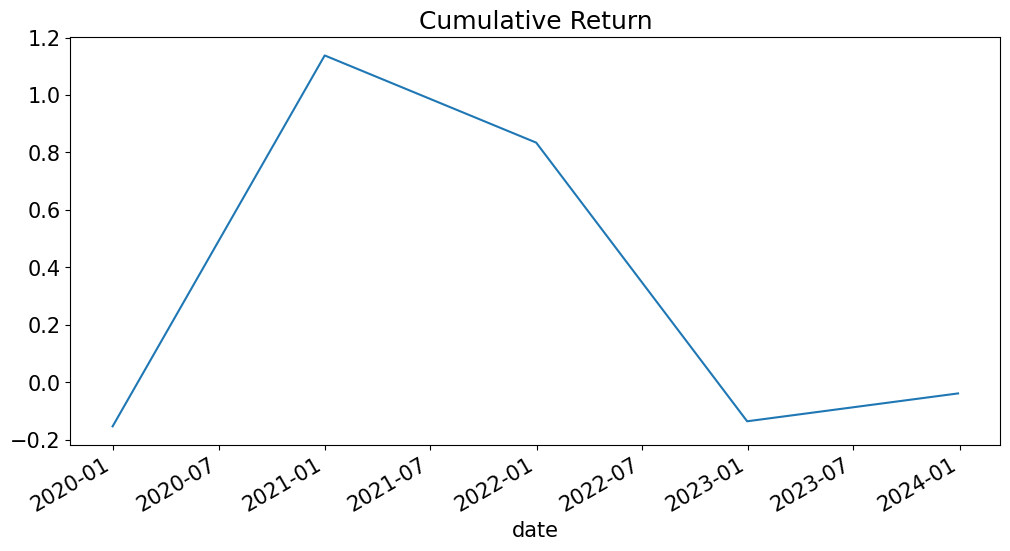

In [132]:
capital = HAIRCUT * INIT_SIZE * 2

cum_ret = pnl['net'].cumsum().drop('cumulative') / capital - 1
cum_ret.name = 'cumulative return'
cum_ret = cum_ret.iloc[1:]
cum_ret.plot(title = 'Cumulative Return')
plt.show()

How would this trade play out if the path of one-year spot rates equaled the forward rates observed in 2018?

The return to holding the 5-year bond would equal the return to holding the one-year bond and rolling it over five years which wouldn't be profitable


Given Fact 3 of the *dynamic* (conditional) tests of EH in notebook W.5., do you expect that as of Dec 2023 the long-short trade above looks more or less favorable for Dec 2023-2028 than it did for Dec 2018-2023?

In [133]:
f-spots

,1,2,3,4,5
date,,,,,
2018-12-31,0.0,-0.001410,-0.000370,0.000908,0.001000
2019-12-31,0.0,0.000048,0.000564,0.001659,0.001204
2020-12-31,0.0,0.000200,0.000658,0.003238,0.004308
2021-12-31,0.0,0.003469,0.004841,0.005463,0.004456
2022-12-30,0.0,-0.002681,-0.004797,-0.003071,-0.002819
2023-12-29,0.0,-0.005430,-0.004972,-0.002170,-0.002487


This is a question as to whether the forward-spot spread is bigger in 2018 or 2023. In W.5., we learned (in Dynamic Fact 3) that in times of higher forward-spot spreads, the expected excess return and realized yields are larger.

The table below shows that the forward-spot spread on 5-year bonds was 10bps in 2018 and negative 25bps in 2023. Thus, we expect that the return to this trade (long 5-year bond, short 1-year bond) will be substantially worse in 2023-2028.